# 爬蟲數據分析專案
以Booking.com熱門城市:東京與其住宿地點分析，觀察後疫情時代旅遊的復興程度

## Author
Finn Ou 2023-02-27


## Main Source
1. df_booking
2. df_booking_detail


## Main Output
1. 住宿標的基本資訊 properties_info
2. 住宿標的詳細資訊 properties_details
3. 住宿標的子評分 properties_subscores


## Step by step
0. Setting up
1. Data Collecting
2. Data Cleaning
3. Data Modeling and Structure
4. Explore Data Analysis

## 0. Setting up

In [ ]:
### import os
import logging
import time
from datetime import datetime
import os
import sys
import re

import random
import json
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.keys import Keys # 鍵盤按鍵
from selenium.webdriver.chrome.options import Options 
from selenium.common.exceptions import NoSuchElementException
# from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from bs4 import BeautifulSoup as bs
import requests
from requests.adapters import HTTPAdapter, Retry
from fake_useragent import UserAgent

import pandas as pd
import numpy as np
import jieba
from collections import Counter
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# datetime
now = datetime.now()
today = now.strftime('%Y%m%d')
current_time = now.strftime('%H%M%S')

# logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger_formatter = logging.Formatter(u'[%(asctime)s][%(levelname)s]: %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

console_handler = logging.StreamHandler(sys.stdout)
console_handler.setFormatter(logger_formatter)
logger.addHandler(console_handler)

# log_path = f'log/{__name__}_{today}.log'
# os.makedirs(os.path.dirname(log_path), exist_ok=True)
# file_handler = logging.FileHandler(log_path)
# file_handler.setFormatter(logger_formatter)
# logger.addHandler(file_handler)

In [3]:
# 設定爬蟲
def _setting_webdriver():
    opts = Options()
    opts.add_argument('--disable-notifications')
    opts.add_argument('--headless')
    opts.add_argument('--incognito') # 使用無痕模式

    opts.add_argument(f'user-agent={UserAgent().random}') 

    chrome = webdriver.Chrome('./chromedriver',chrome_options=opts)
    chrome.maximize_window() # 最大化窗口，因為每一次爬取只能看到視窗内的圖片
    return chrome

In [4]:
delay_choices = [i for i in range(5,11)]  #延遲的秒數
delay = random.choice(delay_choices)  

In [268]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

## 1. Data Collecting

In [1135]:
#### trial_searching list
city_name = 'Tokyo'
check_in = '2023-01-27'
check_out = '2023-01-31'

hotel_url = []
hotel_name = []
hotel_price = []
hotel_score = []
hotel_usefulinfo = []
hotel_area = []
hotel_center_distance = []

logger.info(f'Start searching on booking.com...')

url = f'https://www.booking.com/searchresults.zh-tw.html?ss={city_name}&aid=304142&lang=zh-tw&sb=1&src_elem=sb&src=index&dest_id=-246227&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fa5a43e1198f0184&ac_meta=GhBmYTVhNDNlMTE5OGYwMTg0IAAoATICZW46AnRvQABKAFAA&checkin={check_in}&checkout={check_out}&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure'

chrome = _setting_webdriver()
chrome.get(url)
soup = bs(chrome.page_source,"lxml")


while chrome.find_element(By.XPATH, "//button[@aria-label='下一頁']").is_enabled():
    try:
        logger.info('Going random sleep before trail...')
        time.sleep(random.choice(delay_choices)) 

        # hotel_info
        hotel_url.extend([element['href'] for element in soup.select('.a4225678b2 > a')])
        hotel_name.extend([element.text for element in soup.select('.fcab3ed991.a23c043802')])
        hotel_price.extend([re.search(r'.*TWD\xa0(.*\d{3}).*',element.text).group(1) if element.find('span',attrs={'data-testid':'price-and-discounted-price'}) else np.nan for element in soup.find_all('div',attrs={'data-testid':'property-card'})])
        hotel_score.extend([re.search(r'([0-9]\.[0-9][\u4e00-\u9fa5].*則評語)',element.text).group(1) if re.search(r'([0-9]\.[0-9][\u4e00-\u9fa5].*則評語)',element.text) is not None else None if element.find('div',attrs={'data-testid':'review-score'}) else None for element in soup.find_all('div',attrs={'data-testid':'property-card'})])
        hotel_usefulinfo.extend([element.text if element.select('.df597226dd') else None for element in soup.find_all('div',attrs={'data-testid':'recommended-units'})])
        hotel_area.extend([element.text for element in soup.find_all('span',attrs={'data-testid':'address'})])
        hotel_center_distance.extend([element.text for element in soup.find_all('span',attrs={'data-testid':'distance'})])
            
        logger.info('Going random sleep after trail...')
        time.sleep(random.choice(delay_choices)) 
            
        WebDriverWait(chrome, random.choice(delay_choices)).until(EC.element_to_be_clickable((By.XPATH, "//button[@aria-label='下一頁']"))).click() 
        logger.info(f'url now: {chrome.current_url}')
            
        soup = bs(chrome.page_source,"lxml")


    except Exception as e:
        logger.info(e)
        
    else:
        booking_data = {
            'hotel_url':hotel_url,
            'hotel_name':hotel_name,
            'hotel_price':hotel_price,
            'hotel_score':hotel_score,
            'hotel_usefulinfo':hotel_usefulinfo,
            'hotel_area':hotel_area,
            'hotel_center_distance':hotel_center_distance
        }
        logger.info(f'Stored the hotel_info into a dict...')
                        
logger.info(f'Finish searching on booking.com!')

[2023-01-05 17:54:28][INFO]: Start searching on booking.com...


/tmp/ipykernel_1237/3310080030.py:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  chrome = webdriver.Chrome('./chromedriver',chrome_options=opts)
/tmp/ipykernel_1237/3310080030.py:12: DeprecationWarning: use options instead of chrome_options
  chrome = webdriver.Chrome('./chromedriver',chrome_options=opts)


[2023-01-05 17:54:35][INFO]: Going random sleep before trail...
[2023-01-05 17:54:42][INFO]: Going random sleep after trail...
[2023-01-05 17:54:49][INFO]: url now: https://www.booking.com/searchresults.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ss=Tokyo&lang=zh-tw&sb=1&src_elem=sb&src=index&dest_id=-246227&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fa5a43e1198f0184&ac_meta=GhBmYTVhNDNlMTE5OGYwMTg0IAAoATICZW46AnRvQABKAFAA&checkin=2023-01-27&checkout=2023-01-31&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset=25
[2023-01-05 17:54:50][INFO]: Stored the hotel_info into a dict...
[2023-01-05 17:54:50][INFO]: Going random sleep before trail...
[2023-01-05 17:54:59][INFO]: Going random sleep after trail...
[2023-01-05 17:55:07][INFO]: url now: https://www.b

[2023-01-05 17:57:25][INFO]: Going random sleep before trail...
[2023-01-05 17:57:31][INFO]: Going random sleep after trail...
[2023-01-05 17:57:37][INFO]: url now: https://www.booking.com/searchresults.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ss=Tokyo&lang=zh-tw&sb=1&src_elem=sb&src=index&dest_id=-246227&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fa5a43e1198f0184&ac_meta=GhBmYTVhNDNlMTE5OGYwMTg0IAAoATICZW46AnRvQABKAFAA&checkin=2023-01-27&checkout=2023-01-31&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset=275
[2023-01-05 17:57:38][INFO]: Stored the hotel_info into a dict...
[2023-01-05 17:57:38][INFO]: Going random sleep before trail...
[2023-01-05 17:57:46][INFO]: Going random sleep after trail...
[2023-01-05 17:57:54][INFO]: url now: https://www.

[2023-01-05 17:59:52][INFO]: Going random sleep before trail...
[2023-01-05 17:59:58][INFO]: Going random sleep after trail...
[2023-01-05 18:00:03][INFO]: url now: https://www.booking.com/searchresults.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ss=Tokyo&lang=zh-tw&sb=1&src_elem=sb&src=index&dest_id=-246227&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fa5a43e1198f0184&ac_meta=GhBmYTVhNDNlMTE5OGYwMTg0IAAoATICZW46AnRvQABKAFAA&checkin=2023-01-27&checkout=2023-01-31&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset=525
[2023-01-05 18:00:03][INFO]: Stored the hotel_info into a dict...
[2023-01-05 18:00:03][INFO]: Going random sleep before trail...
[2023-01-05 18:00:12][INFO]: Going random sleep after trail...
[2023-01-05 18:00:18][INFO]: url now: https://www.

[2023-01-05 18:02:30][INFO]: Going random sleep before trail...
[2023-01-05 18:02:35][INFO]: Going random sleep after trail...
[2023-01-05 18:02:41][INFO]: url now: https://www.booking.com/searchresults.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ss=Tokyo&lang=zh-tw&sb=1&src_elem=sb&src=index&dest_id=-246227&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fa5a43e1198f0184&ac_meta=GhBmYTVhNDNlMTE5OGYwMTg0IAAoATICZW46AnRvQABKAFAA&checkin=2023-01-27&checkout=2023-01-31&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset=775
[2023-01-05 18:02:41][INFO]: Stored the hotel_info into a dict...
[2023-01-05 18:02:41][INFO]: Going random sleep before trail...
[2023-01-05 18:02:50][INFO]: Going random sleep after trail...
[2023-01-05 18:02:57][INFO]: url now: https://www.

In [ ]:
#### trial_hotel detail info
# city_name = 'Tokyo'
# check_in = '2023-01-27'
# check_out = '2023-01-31'

booking_detail_data = {}

logger.info(f'Start searching details on booking.com...')

for _,url in enumerate(booking_data['hotel_url']):
    chrome = _setting_webdriver()
    chrome.get(url)
    soup = bs(chrome.page_source,"lxml")

    try:
        logger.info('Going random sleep before trail...')
        time.sleep(random.choice(delay_choices)) 

        # hotel_detail_info
        for element in soup.select('.d2fee87262.pp-header__title'):
            hotel_name = element.text
        for element in soup.select('.hp__hotel-title.pp-header'):
            if element.select('span.fbb11b26f5.e23c0b1d74'):
                hotel_stars = len(element.select('.b6dc9a9e69.adc357e4f1.fe621d6382')) if element.select('span.fbb11b26f5.e23c0b1d74')[0].get("data-testid") == "rating-stars" else 0
                hotel_squares = len(element.select('.b6dc9a9e69.adc357e4f1.fe621d6382')) if element.select('span.fbb11b26f5.e23c0b1d74')[0].get("data-testid") == "rating-squares" else 0
            else:
                hotel_stars = 0
                hotel_squares = 0
        for element in soup.select('.hp_address_subtitle.js-hp_address_subtitle.jq_tooltip'):
            hotel_addr = element.text.strip()
        for element in soup.select('.hotel-facilities__list'):
            hotel_facilities = [i.text.strip() for i in element.select('.bui-title__text.hotel-facilities-group__title-text')] 
        hotel_subscore = sorted(list(set(element.text for element in soup.find_all('div',attrs={'data-testid':'review-subscore'}))))
        hotel_hot = [element.text for element in soup.select('.bui-spacer--larger')]
        hotel_highlights = [element.text for element in soup.select('.ph-section')]
     
        logger.info('Going random sleep after trail...')
        time.sleep(random.choice(delay_choices)) 
        
        logger.info(f'url now: #{_}, {chrome.current_url}')


    except Exception as e:
        logger.info(e)
        
    else:
        booking_detail_data[url] = {
            'hotel_name':hotel_name,
            'hotel_stars':hotel_stars,
            'hotel_squares':hotel_squares,
            'hotel_addr':hotel_addr,
            'hotel_facilities':hotel_facilities,
            'hotel_subscore':hotel_subscore,
            'hotel_hot':hotel_hot,
            'hotel_highlights':hotel_highlights
        }
        logger.info(f'Stored the hotel_detail_info into a dict...')
                        
logger.info(f'Finish searching details on booking.com!')

[2023-01-05 18:04:46][INFO]: Start searching details on booking.com...


/tmp/ipykernel_1237/3310080030.py:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  chrome = webdriver.Chrome('./chromedriver',chrome_options=opts)
/tmp/ipykernel_1237/3310080030.py:12: DeprecationWarning: use options instead of chrome_options
  chrome = webdriver.Chrome('./chromedriver',chrome_options=opts)


[2023-01-05 18:04:53][INFO]: Going random sleep before trail...
[2023-01-05 18:04:59][INFO]: Going random sleep after trail...
[2023-01-05 18:05:08][INFO]: url now: #0, https://www.booking.com/hotel/jp/the-kanzashi-tokyo-asakusa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=1&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=705312302_343603027_2_2_0&highlighted_blocks=705312302_343603027_2_2_0&matching_block_id=705312302_343603027_2_2_0&sr_pri_blocks=705312302_343603027_2_2_0__5411406&from=searchresults#hotelTmpl
[2023-01-05 18:05:08][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:05:16][INFO]: Going random sleep before trail...
[2023-01-05 18:05:24][

[2023-01-05 18:08:26][INFO]: Going random sleep after trail...
[2023-01-05 18:08:36][INFO]: url now: #9, https://www.booking.com/hotel/jp/comfort-tokyo-kiyosumi-shirakawa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=10&hapos=10&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=62204802_222473114_2_1_0&highlighted_blocks=62204802_222473114_2_1_0&matching_block_id=62204802_222473114_2_1_0&sr_pri_blocks=62204802_222473114_2_1_0__3946635&from=searchresults#hotelTmpl
[2023-01-05 18:08:36][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:08:46][INFO]: Going random sleep before trail...
[2023-01-05 18:08:55][INFO]: Going random sleep after trail...
[2023-01-05 18:09:0

[2023-01-05 18:11:38][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:11:46][INFO]: Going random sleep before trail...
[2023-01-05 18:11:52][INFO]: Going random sleep after trail...
[2023-01-05 18:12:02][INFO]: url now: #18, https://www.booking.com/hotel/jp/jia-cheng-hoterujin-tie-dong-jing-dong-jing-gao-lun.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=19&hapos=19&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=376598302_120383392_0_10_0&highlighted_blocks=376598302_120383392_0_10_0&matching_block_id=376598302_120383392_0_10_0&sr_pri_blocks=376598302_120383392_0_10_0__6769400&from=searchresults#hotelTmpl
[2023-01-05 18:12:02][INFO]: Stored the hotel_detail_i

[2023-01-05 18:15:13][INFO]: Going random sleep before trail...
[2023-01-05 18:15:21][INFO]: Going random sleep after trail...
[2023-01-05 18:15:29][INFO]: url now: #27, https://www.booking.com/hotel/jp/richmond-tokyo-suidobashi.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=3&hapos=3&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=106900901_209807067_0_2_0&highlighted_blocks=106900901_209807067_0_2_0&matching_block_id=106900901_209807067_0_2_0&sr_pri_blocks=106900901_209807067_0_2_0__5628700&from=searchresults#hotelTmpl
[2023-01-05 18:15:29][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:15:35][INFO]: Going random sleep before trail...
[2023-01-05 18:15:45][

[2023-01-05 18:18:19][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:18:28][INFO]: Going random sleep before trail...
[2023-01-05 18:18:34][INFO]: Going random sleep after trail...
[2023-01-05 18:18:43][INFO]: url now: #36, https://www.booking.com/hotel/jp/mystays-akasaka.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=12&hapos=12&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=174729919_123048092_0_2_0&highlighted_blocks=174729919_123048092_0_2_0&matching_block_id=174729919_123048092_0_2_0&sr_pri_blocks=174729919_123048092_0_2_0__4421000&from=searchresults#hotelTmpl
[2023-01-05 18:18:43][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:18:50]

[2023-01-05 18:21:51][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:21:53][INFO]: Going random sleep before trail...
[2023-01-05 18:22:00][INFO]: Going random sleep after trail...
[2023-01-05 18:22:05][INFO]: url now: #45, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=c840d9f902429699dfc35be79536c730&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fueno-first-city.zh-tw.html%3Fall_sr_blocks%3D25134905_274220523_2_10_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26group_adults%3D2%26group_children%3D0%26hapos%3D21%26highlighted_blocks%3D25134905_274220523_2_10_0%26hpos%3D21%26matching_block_id%3D25134905_274220523_2_10_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3D0%26sr_order%3Dpopularity%26sr_pri_blocks%3D25134

[2023-01-05 18:25:01][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:25:08][INFO]: Going random sleep before trail...
[2023-01-05 18:25:17][INFO]: Going random sleep after trail...
[2023-01-05 18:25:24][INFO]: url now: #54, https://www.booking.com/hotel/jp/cvsbay.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=5&hapos=30&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941291&all_sr_blocks=261596536_342032742_0_1_0&highlighted_blocks=261596536_342032742_0_1_0&matching_block_id=261596536_342032742_0_1_0&sr_pri_blocks=261596536_342032742_0_1_0__4525400&from=searchresults#hotelTmpl
[2023-01-05 18:25:24][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:25:33][INFO]: Go

[2023-01-05 18:28:49][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:28:58][INFO]: Going random sleep before trail...
[2023-01-05 18:29:07][INFO]: Going random sleep after trail...
[2023-01-05 18:29:16][INFO]: url now: #64, https://www.booking.com/hotel/jp/chinzanso-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=15&hapos=40&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941291&all_sr_blocks=43599854_137639610_0_2_0&highlighted_blocks=43599854_137639610_0_2_0&matching_block_id=43599854_137639610_0_2_0&sr_pri_blocks=43599854_137639610_0_2_0__16376896&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 18:29:16][INFO]: Stored the hotel_detail_info into a d

[2023-01-05 18:33:00][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:33:07][INFO]: Going random sleep before trail...
[2023-01-05 18:33:12][INFO]: Going random sleep after trail...
[2023-01-05 18:33:22][INFO]: url now: #74, https://www.booking.com/hotel/jp/xiang-tie-huretusain-da-men-yi-qian.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=25&hapos=50&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941291&all_sr_blocks=779064002_338543202_2_2_0&highlighted_blocks=779064002_338543202_2_2_0&matching_block_id=779064002_338543202_2_2_0&sr_pri_blocks=779064002_338543202_2_2_0__5769000&from=searchresults#hotelTmpl
[2023-01-05 18:33:22][INFO]: Stored the hotel_detail_info into a dict...
[

[2023-01-05 18:36:16][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:36:24][INFO]: Going random sleep before trail...
[2023-01-05 18:36:33][INFO]: Going random sleep after trail...
[2023-01-05 18:36:40][INFO]: url now: #83, https://www.booking.com/hotel/jp/ibis-styles-tokyo-bay.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=9&hapos=59&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941309&all_sr_blocks=380855604_123627663_2_2_0&highlighted_blocks=380855604_123627663_2_2_0&matching_block_id=380855604_123627663_2_2_0&sr_pri_blocks=380855604_123627663_2_2_0__5950000&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 18:36:40][INFO]: Stored the hotel_detail_info 

[2023-01-05 18:39:46][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:39:53][INFO]: Going random sleep before trail...
[2023-01-05 18:40:03][INFO]: Going random sleep after trail...
[2023-01-05 18:40:11][INFO]: url now: #92, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=6e5f3fd3f5b34e5d62dc10f5c0a88f46&return_url=https%3A%2F%2Fwww.booking.com%2Findex.html&#hotelTmpl
[2023-01-05 18:40:11][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:40:20][INFO]: Going random sleep before trail...
[2023-01-05 18:40:27][INFO]: Going random sleep after trail...
[2023-01-05 18:40:32][INFO]: url now: #93, https://www.booking.com/hotel/jp/ana-intercontinental-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NG

[2023-01-05 18:43:31][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:43:40][INFO]: Going random sleep before trail...
[2023-01-05 18:43:47][INFO]: Going random sleep after trail...
[2023-01-05 18:43:56][INFO]: url now: #102, https://www.booking.com/hotel/jp/mitsui-garden-otemachi.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=3&hapos=78&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941330&all_sr_blocks=293171901_195378686_0_0_0&highlighted_blocks=293171901_195378686_0_0_0&matching_block_id=293171901_195378686_0_0_0&sr_pri_blocks=293171901_195378686_0_0_0__8241090&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 18:43:56][INFO]: Stored the hotel_detail_inf

[2023-01-05 18:47:09][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:47:16][INFO]: Going random sleep before trail...
[2023-01-05 18:47:25][INFO]: Going random sleep after trail...
[2023-01-05 18:47:32][INFO]: url now: #111, https://www.booking.com/hotel/jp/new-otani-tokyo-garden-tower.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=12&hapos=87&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941330&all_sr_blocks=119934310_355532679_2_0_0&highlighted_blocks=119934310_355532679_2_0_0&matching_block_id=119934310_355532679_2_0_0&sr_pri_blocks=119934310_355532679_2_0_0__15139800&from=searchresults#hotelTmpl
[2023-01-05 18:47:32][INFO]: Stored the hotel_detail_info into a dict...
[2023-

[2023-01-05 18:50:37][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:50:44][INFO]: Going random sleep before trail...
[2023-01-05 18:50:50][INFO]: Going random sleep after trail...
[2023-01-05 18:50:56][INFO]: url now: #120, https://www.booking.com/hotel/jp/hyatt-regency-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=21&hapos=96&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941330&all_sr_blocks=26103114_263861846_2_2_0&highlighted_blocks=26103114_263861846_2_2_0&matching_block_id=26103114_263861846_2_2_0&sr_pri_blocks=26103114_263861846_2_2_0__20812000&from=searchresults#hotelTmpl
[2023-01-05 18:50:56][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:51:0

[2023-01-05 18:54:13][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:54:20][INFO]: Going random sleep before trail...
[2023-01-05 18:54:28][INFO]: Going random sleep after trail...
[2023-01-05 18:54:33][INFO]: url now: #129, https://www.booking.com/hotel/jp/apa-sugamo-ekimae.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=5&hapos=105&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941344&all_sr_blocks=167687403_196075981_0_2_0&highlighted_blocks=167687403_196075981_0_2_0&matching_block_id=167687403_196075981_0_2_0&sr_pri_blocks=167687403_196075981_0_2_0__5535200&from=searchresults#hotelTmpl
[2023-01-05 18:54:33][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:54:

[2023-01-05 18:58:05][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:58:12][INFO]: Going random sleep before trail...
[2023-01-05 18:58:21][INFO]: Going random sleep after trail...
[2023-01-05 18:58:27][INFO]: url now: #139, https://www.booking.com/hotel/jp/cvsbay-xin-guan.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=15&hapos=115&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941344&all_sr_blocks=261600804_240886578_0_1_0&highlighted_blocks=261600804_240886578_0_1_0&matching_block_id=261600804_240886578_0_1_0&sr_pri_blocks=261600804_240886578_0_1_0__3777400&from=searchresults#hotelTmpl
[2023-01-05 18:58:27][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 18:58:3

[2023-01-05 19:01:20][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:01:28][INFO]: Going random sleep before trail...
[2023-01-05 19:01:39][INFO]: Going random sleep after trail...
[2023-01-05 19:01:44][INFO]: url now: #148, https://www.booking.com/hotel/jp/pullman-tokyo-tamachi.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=24&hapos=124&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941344&all_sr_blocks=393769213_128236379_2_1_0&highlighted_blocks=393769213_128236379_2_1_0&matching_block_id=393769213_128236379_2_1_0&sr_pri_blocks=393769213_128236379_2_1_0__17370000&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 19:01:44][INFO]: Stored the hotel_detail_i

[2023-01-05 19:04:43][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:04:50][INFO]: Going random sleep before trail...
[2023-01-05 19:04:56][INFO]: Going random sleep after trail...
[2023-01-05 19:05:02][INFO]: url now: #157, https://www.booking.com/hotel/jp/wing-international-ueno-okachimachi.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=8&hapos=133&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941358&all_sr_blocks=252594906_278855325_2_1_0&highlighted_blocks=252594906_278855325_2_1_0&matching_block_id=252594906_278855325_2_1_0&sr_pri_blocks=252594906_278855325_2_1_0__5486580&from=searchresults#hotelTmpl
[2023-01-05 19:05:02][INFO]: Stored the hotel_detail_info into a dict...


[2023-01-05 19:07:53][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:08:00][INFO]: Going random sleep before trail...
[2023-01-05 19:08:10][INFO]: Going random sleep after trail...
[2023-01-05 19:08:18][INFO]: url now: #166, https://www.booking.com/hotel/jp/hotel-yaenomidori-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=17&hapos=142&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941358&all_sr_blocks=516349203_221729525_2_2_0&highlighted_blocks=516349203_221729525_2_2_0&matching_block_id=516349203_221729525_2_2_0&sr_pri_blocks=516349203_221729525_2_2_0__8793675&from=searchresults#hotelTmpl
[2023-01-05 19:08:18][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05

[2023-01-05 19:11:16][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:11:23][INFO]: Going random sleep before trail...
[2023-01-05 19:11:33][INFO]: Going random sleep after trail...
[2023-01-05 19:11:41][INFO]: url now: #175, https://www.booking.com/hotel/jp/mimaru-tokyo-hatchobori.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=151&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941377&all_sr_blocks=414240101_328381950_0_0_0&highlighted_blocks=414240101_328381950_0_0_0&matching_block_id=414240101_328381950_0_0_0&sr_pri_blocks=414240101_328381950_0_0_0__20289500&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 19:11:41][INFO]: Stored the hotel_detail_

[2023-01-05 19:15:31][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:15:40][INFO]: Going random sleep before trail...
[2023-01-05 19:15:47][INFO]: Going random sleep after trail...
[2023-01-05 19:15:52][INFO]: url now: #185, https://www.booking.com/hotel/jp/wing-international-select-asakusa-komagata.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=11&hapos=161&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941377&all_sr_blocks=201590004_207359913_0_2_0&highlighted_blocks=201590004_207359913_0_2_0&matching_block_id=201590004_207359913_0_2_0&sr_pri_blocks=201590004_207359913_0_2_0__5236000&from=searchresults#hotelTmpl
[2023-01-05 19:15:52][INFO]: Stored the hotel_detail_info into a 

[2023-01-05 19:18:54][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:19:02][INFO]: Going random sleep before trail...
[2023-01-05 19:19:13][INFO]: Going random sleep after trail...
[2023-01-05 19:19:18][INFO]: url now: #194, https://www.booking.com/hotel/jp/mitsui-garden-gotanda-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=20&hapos=170&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941377&all_sr_blocks=293171302_195400303_0_2_0&highlighted_blocks=293171302_195400303_0_2_0&matching_block_id=293171302_195400303_0_2_0&sr_pri_blocks=293171302_195400303_0_2_0__9188058&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 19:19:18][INFO]: Stored the hotel_det

[2023-01-05 19:22:28][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:22:37][INFO]: Going random sleep before trail...
[2023-01-05 19:22:45][INFO]: Going random sleep after trail...
[2023-01-05 19:22:53][INFO]: url now: #203, https://www.booking.com/hotel/jp/apa-hotel-higashi-nihombashi-ekimae.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=4&hapos=179&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941389&all_sr_blocks=107291703_195216635_0_2_0&highlighted_blocks=107291703_195216635_0_2_0&matching_block_id=107291703_195216635_0_2_0&sr_pri_blocks=107291703_195216635_0_2_0__5264050&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 19:22:53][INFO]: Stored the ho

[2023-01-05 19:25:43][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:25:50][INFO]: Going random sleep before trail...
[2023-01-05 19:25:55][INFO]: Going random sleep after trail...
[2023-01-05 19:26:05][INFO]: url now: #212, https://www.booking.com/hotel/jp/best-western-hotel-fino-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=13&hapos=188&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941389&all_sr_blocks=348189701_335427959_0_2_0&highlighted_blocks=348189701_335427959_0_2_0&matching_block_id=348189701_335427959_0_2_0&sr_pri_blocks=348189701_335427959_0_2_0__6573050&from=searchresults#hotelTmpl
[2023-01-05 19:26:05][INFO]: Stored the hotel_detail_info into a dict...
[2023

[2023-01-05 19:29:06][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:29:14][INFO]: Going random sleep before trail...
[2023-01-05 19:29:20][INFO]: Going random sleep after trail...
[2023-01-05 19:29:30][INFO]: url now: #221, https://www.booking.com/hotel/jp/hua-zhu-qian-cao-he-xin-hoteru.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=22&hapos=197&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941389&all_sr_blocks=916684004_365116390_0_0_0&highlighted_blocks=916684004_365116390_0_0_0&matching_block_id=916684004_365116390_0_0_0&sr_pri_blocks=916684004_365116390_0_0_0__5566523&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 19:29:30][INFO]: Stored the hotel_

[2023-01-05 19:32:28][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:32:35][INFO]: Going random sleep before trail...
[2023-01-05 19:32:44][INFO]: Going random sleep after trail...
[2023-01-05 19:32:51][INFO]: url now: #231, https://www.booking.com/hotel/jp/hoteruasuka.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=7&hapos=207&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941408&all_sr_blocks=250242520_247100326_2_0_0&highlighted_blocks=250242520_247100326_2_0_0&matching_block_id=250242520_247100326_2_0_0&sr_pri_blocks=250242520_247100326_2_0_0__2398275&from=searchresults#hotelTmpl
[2023-01-05 19:32:51][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:33:00][IN

[2023-01-05 19:35:58][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:36:04][INFO]: Going random sleep before trail...
[2023-01-05 19:36:09][INFO]: Going random sleep after trail...
[2023-01-05 19:36:19][INFO]: url now: #240, https://www.booking.com/hotel/jp/mimaru-tokyo-inaricho-dong-jing-du.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=16&hapos=216&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941408&all_sr_blocks=338055309_328382115_4_0_0&highlighted_blocks=338055309_328382115_4_0_0&matching_block_id=338055309_328382115_4_0_0&sr_pri_blocks=338055309_328382115_4_0_0__22678425&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 19:36:19][INFO]: Stored the h

[2023-01-05 19:40:13][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:40:23][INFO]: Going random sleep before trail...
[2023-01-05 19:40:30][INFO]: Going random sleep after trail...
[2023-01-05 19:40:37][INFO]: url now: #251, https://www.booking.com/hotel/jp/apa-nihonbashi-hamachoeki-minami.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=227&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941432&all_sr_blocks=35978705_196080910_0_2_0&highlighted_blocks=35978705_196080910_0_2_0&matching_block_id=35978705_196080910_0_2_0&sr_pri_blocks=35978705_196080910_0_2_0__5030300&from=searchresults#hotelTmpl
[2023-01-05 19:40:37][INFO]: Stored the hotel_detail_info into a dict...
[2023-0

[2023-01-05 19:43:34][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:43:41][INFO]: Going random sleep before trail...
[2023-01-05 19:43:52][INFO]: Going random sleep after trail...
[2023-01-05 19:44:01][INFO]: url now: #260, https://www.booking.com/hotel/jp/apa-mitaekimae.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=11&hapos=236&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941432&all_sr_blocks=42655426_196080159_0_2_0&highlighted_blocks=42655426_196080159_0_2_0&matching_block_id=42655426_196080159_0_2_0&sr_pri_blocks=42655426_196080159_0_2_0__5179900&from=searchresults#hotelTmpl
[2023-01-05 19:44:01][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:44:08][IN

[2023-01-05 19:47:09][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:47:26][INFO]: Going random sleep before trail...
[2023-01-05 19:47:32][INFO]: Going random sleep after trail...
[2023-01-05 19:47:37][INFO]: url now: #269, https://www.booking.com/hotel/jp/hilton-tokyo-odaiba.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=20&hapos=245&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941432&all_sr_blocks=25576745_95460549_2_1_0&highlighted_blocks=25576745_95460549_2_1_0&matching_block_id=25576745_95460549_2_1_0&sr_pri_blocks=25576745_95460549_2_1_0__13771000&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 19:47:37][INFO]: Stored the hotel_detail_info into a

[2023-01-05 19:50:19][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:50:22][INFO]: Going random sleep before trail...
[2023-01-05 19:50:27][INFO]: Going random sleep after trail...
[2023-01-05 19:50:34][INFO]: url now: #278, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=38a7fee6a7e8d37021b7ff40a1e2c644&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fnine-hours-suidobashi.zh-tw.html%3Fall_sr_blocks%3D554152620_251216077_2_0_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26group_adults%3D2%26group_children%3D0%26hapos%3D254%26highlighted_blocks%3D554152620_251216077_2_0_0%26hpos%3D4%26matching_block_id%3D554152620_251216077_2_0_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3D0%26sr_order%3Dpopularity%26sr_pri_blocks%

[2023-01-05 19:53:48][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:53:58][INFO]: Going random sleep before trail...
[2023-01-05 19:54:08][INFO]: Going random sleep after trail...
[2023-01-05 19:54:16][INFO]: url now: #287, https://www.booking.com/hotel/jp/bian-nahoterudong-jing-bang-song-ting.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=13&hapos=263&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941446&all_sr_blocks=273747826_106431468_2_2_0&highlighted_blocks=273747826_106431468_2_2_0&matching_block_id=273747826_106431468_2_2_0&sr_pri_blocks=273747826_106431468_2_2_0__4712400&from=searchresults#hotelTmpl
[2023-01-05 19:54:16][INFO]: Stored the hotel_detail_info into a dict.

[2023-01-05 19:57:32][INFO]: Going random sleep after trail...
[2023-01-05 19:57:41][INFO]: url now: #296, https://www.booking.com/hotel/jp/new-otani-inn-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=22&hapos=272&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941446&all_sr_blocks=32792723_190250429_2_2_0&highlighted_blocks=32792723_190250429_2_2_0&matching_block_id=32792723_190250429_2_2_0&sr_pri_blocks=32792723_190250429_2_2_0__6102000&from=searchresults#hotelTmpl
[2023-01-05 19:57:41][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 19:57:47][INFO]: Going random sleep before trail...
[2023-01-05 19:57:56][INFO]: Going random sleep after trail...
[2023-01-05 19:58:06][INFO]: 

[2023-01-05 20:00:58][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:01:05][INFO]: Going random sleep before trail...
[2023-01-05 20:01:10][INFO]: Going random sleep after trail...
[2023-01-05 20:01:19][INFO]: url now: #306, https://www.booking.com/hotel/jp/uhome-big-house-near-kanda-station.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=7&hapos=282&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941459&all_sr_blocks=323042316_146181360_2_0_0&highlighted_blocks=323042316_146181360_2_0_0&matching_block_id=323042316_146181360_2_0_0&sr_pri_blocks=323042316_146181360_2_0_0__4525400&from=searchresults#hotelTmpl
[2023-01-05 20:01:19][INFO]: Stored the hotel_detail_info into a dict...
[

[2023-01-05 20:04:15][INFO]: Going random sleep before trail...
[2023-01-05 20:04:21][INFO]: Going random sleep after trail...
[2023-01-05 20:04:27][INFO]: url now: #315, https://www.booking.com/hotel/jp/the-share-hotels-kaika-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=16&hapos=291&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941459&all_sr_blocks=581041512_225960904_3_2_0&highlighted_blocks=581041512_225960904_3_2_0&matching_block_id=581041512_225960904_3_2_0&sr_pri_blocks=581041512_225960904_3_2_0__8806500&from=searchresults#hotelTmpl
[2023-01-05 20:04:27][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:04:34][INFO]: Going random sleep before trail...
[2023-01-05 20:

[2023-01-05 20:08:04][INFO]: Going random sleep before trail...
[2023-01-05 20:08:14][INFO]: Going random sleep after trail...
[2023-01-05 20:08:21][INFO]: url now: #325, https://www.booking.com/hotel/jp/hotel-amanek-ginza-east.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=301&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941476&all_sr_blocks=176871202_247425929_0_0_0&highlighted_blocks=176871202_247425929_0_0_0&matching_block_id=176871202_247425929_0_0_0&sr_pri_blocks=176871202_247425929_0_0_0__6253093&from=searchresults#hotelTmpl
[2023-01-05 20:08:21][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:08:28][INFO]: Going random sleep before trail...
[2023-01-05 20:08:35]

[2023-01-05 20:11:12][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:11:20][INFO]: Going random sleep before trail...
[2023-01-05 20:11:25][INFO]: Going random sleep after trail...
[2023-01-05 20:11:31][INFO]: url now: #334, https://www.booking.com/hotel/jp/sakura-ikebukuro.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=10&hapos=310&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941476&all_sr_blocks=23625701_190231212_2_2_0&highlighted_blocks=23625701_190231212_2_2_0&matching_block_id=23625701_190231212_2_2_0&sr_pri_blocks=23625701_190231212_2_2_0__4174775&from=searchresults#hotelTmpl
[2023-01-05 20:11:31][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:11:39][

[2023-01-05 20:14:22][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:14:29][INFO]: Going random sleep before trail...
[2023-01-05 20:14:36][INFO]: Going random sleep after trail...
[2023-01-05 20:14:46][INFO]: url now: #343, https://www.booking.com/hotel/jp/vistahotel-kamata.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=19&hapos=319&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941476&all_sr_blocks=28355583_295220836_2_2_0&highlighted_blocks=28355583_295220836_2_2_0&matching_block_id=28355583_295220836_2_2_0&sr_pri_blocks=28355583_295220836_2_2_0__2960397&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 20:14:46][INFO]: Stored the hotel_detail_info into 

[2023-01-05 20:17:44][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:17:51][INFO]: Going random sleep before trail...
[2023-01-05 20:17:58][INFO]: Going random sleep after trail...
[2023-01-05 20:18:07][INFO]: url now: #352, https://www.booking.com/hotel/jp/the-kanzashi-tokyo-asakusa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=3&hapos=328&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941489&all_sr_blocks=705312302_343603027_2_2_0&highlighted_blocks=705312302_343603027_2_2_0&matching_block_id=705312302_343603027_2_2_0&sr_pri_blocks=705312302_343603027_2_2_0__5411406&from=searchresults#hotelTmpl
[2023-01-05 20:18:07][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-

[2023-01-05 20:21:28][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:21:34][INFO]: Going random sleep before trail...
[2023-01-05 20:21:45][INFO]: Going random sleep after trail...
[2023-01-05 20:21:53][INFO]: url now: #361, https://www.booking.com/hotel/jp/sakura-ryokan.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=12&hapos=337&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941489&all_sr_blocks=24928418_241757494_2_0_0&highlighted_blocks=24928418_241757494_2_0_0&matching_block_id=24928418_241757494_2_0_0&sr_pri_blocks=24928418_241757494_2_0_0__4792810&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 20:21:53][INFO]: Stored the hotel_detail_info into a di

[2023-01-05 20:25:02][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:25:11][INFO]: Going random sleep before trail...
[2023-01-05 20:25:19][INFO]: Going random sleep after trail...
[2023-01-05 20:25:26][INFO]: url now: #370, https://www.booking.com/hotel/jp/mystays-haneda.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=21&hapos=346&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941489&all_sr_blocks=109991401_239820167_2_2_0&highlighted_blocks=109991401_239820167_2_2_0&matching_block_id=109991401_239820167_2_2_0&sr_pri_blocks=109991401_239820167_2_2_0__5629000&from=searchresults#hotelTmpl
[2023-01-05 20:25:26][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:25:32

[2023-01-05 20:28:17][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:28:24][INFO]: Going random sleep before trail...
[2023-01-05 20:28:33][INFO]: Going random sleep after trail...
[2023-01-05 20:28:38][INFO]: url now: #379, https://www.booking.com/hotel/jp/mitsui-garden-ginza-premier-chuo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=9eb0a83141abdc5ecc5743c88d337b96&all_sr_blocks=25998704_241770855_0_0_0;checkin=2023-01-27;checkout=2023-01-31;dest_id=-246227;dest_type=city;dist=0;group_adults=2;group_children=0;hapos=355;highlighted_blocks=25998704_241770855_0_0_0;hpos=5;matching_block_id=25998704_241770855_0_0_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=25998704_241770855_0_0_0__12083379;srepoch=1672941505;srpvid=a9d57debee5300b8;type=total;ucfs=1&#hotelTmpl
[2023-01-05 20:28:3

[2023-01-05 20:31:59][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:32:08][INFO]: Going random sleep before trail...
[2023-01-05 20:32:16][INFO]: Going random sleep after trail...
[2023-01-05 20:32:25][INFO]: url now: #389, https://www.booking.com/hotel/jp/daiichi-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=15&hapos=365&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941505&all_sr_blocks=39144705_91473959_2_2_0&highlighted_blocks=39144705_91473959_2_2_0&matching_block_id=39144705_91473959_2_2_0&sr_pri_blocks=39144705_91473959_2_2_0__15399450&from=searchresults#hotelTmpl
[2023-01-05 20:32:25][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:32:33][INFO]:

[2023-01-05 20:35:27][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:35:33][INFO]: Going random sleep before trail...
[2023-01-05 20:35:42][INFO]: Going random sleep after trail...
[2023-01-05 20:35:48][INFO]: url now: #398, https://www.booking.com/hotel/jp/rahuitutoliang-guo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=24&hapos=374&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941505&all_sr_blocks=732058909_351632504_2_0_0&highlighted_blocks=732058909_351632504_2_0_0&matching_block_id=732058909_351632504_2_0_0&sr_pri_blocks=732058909_351632504_2_0_0__6695535&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 20:35:48][INFO]: Stored the hotel_detail_info 

[2023-01-05 20:38:29][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:38:35][INFO]: Going random sleep before trail...
[2023-01-05 20:38:45][INFO]: Going random sleep after trail...
[2023-01-05 20:38:50][INFO]: url now: #407, https://www.booking.com/hotel/jp/easy-access-to-skytree-studio-bell-flat-inn-4.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=8&hapos=383&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941520&all_sr_blocks=930895101_365109616_2_0_0&highlighted_blocks=930895101_365109616_2_0_0&matching_block_id=930895101_365109616_2_0_0&sr_pri_blocks=930895101_365109616_2_0_0__2994000&from=searchresults#hotelTmpl
[2023-01-05 20:38:50][INFO]: Stored the hotel_detail_info into 

[2023-01-05 20:42:09][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:42:16][INFO]: Going random sleep before trail...
[2023-01-05 20:42:25][INFO]: Going random sleep after trail...
[2023-01-05 20:42:35][INFO]: url now: #417, https://www.booking.com/hotel/jp/cen.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=18&hapos=393&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941520&all_sr_blocks=498952601_168467569_2_2_0&highlighted_blocks=498952601_168467569_2_2_0&matching_block_id=498952601_168467569_2_2_0&sr_pri_blocks=498952601_168467569_2_2_0__8684154&from=searchresults#hotelTmpl
[2023-01-05 20:42:35][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:42:41][INFO]: Go

[2023-01-05 20:45:43][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:45:51][INFO]: Going random sleep before trail...
[2023-01-05 20:46:01][INFO]: Going random sleep after trail...
[2023-01-05 20:46:10][INFO]: url now: #426, https://www.booking.com/hotel/jp/super-hotel-lohas-akasaka.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=402&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941533&all_sr_blocks=128683515_93272735_0_2_0&highlighted_blocks=128683515_93272735_0_2_0&matching_block_id=128683515_93272735_0_2_0&sr_pri_blocks=128683515_93272735_0_2_0__5560000&from=searchresults#hotelTmpl
[2023-01-05 20:46:10][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20

[2023-01-05 20:49:34][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:49:36][INFO]: Going random sleep before trail...
[2023-01-05 20:49:42][INFO]: Going random sleep after trail...
[2023-01-05 20:49:52][INFO]: url now: #436, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=1a4503e8927da6970a85642b79f133c5&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fgrand-hyatt-tokyo.zh-tw.html%3Fall_sr_blocks%3D62600713_263861829_2_2_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26from_sustainable_property_sr%3D1%26group_adults%3D2%26group_children%3D0%26hapos%3D412%26highlighted_blocks%3D62600713_263861829_2_2_0%26hpos%3D12%26matching_block_id%3D62600713_263861829_2_2_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3D0%26sr_order%

[2023-01-05 20:53:11][INFO]: Going random sleep before trail...
[2023-01-05 20:53:19][INFO]: Going random sleep after trail...
[2023-01-05 20:53:26][INFO]: url now: #445, https://www.booking.com/hotel/jp/jr-east-mets-gotanda.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=21&hapos=421&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941533&all_sr_blocks=904338002_362134267_2_0_0&highlighted_blocks=904338002_362134267_2_0_0&matching_block_id=904338002_362134267_2_0_0&sr_pri_blocks=904338002_362134267_2_0_0__8424350&from=searchresults#hotelTmpl
[2023-01-05 20:53:26][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:53:33][INFO]: Going random sleep before trail...
[2023-01-05 20:53:41][I

[2023-01-05 20:56:37][INFO]: url now: #454, https://www.booking.com/hotel/jp/base-hanegi-apartment.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=5&hapos=430&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941548&all_sr_blocks=650440901_266039122_3_0_0&highlighted_blocks=650440901_266039122_3_0_0&matching_block_id=650440901_266039122_3_0_0&sr_pri_blocks=650440901_266039122_3_0_0__5389340&from=searchresults#hotelTmpl
[2023-01-05 20:56:37][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:56:45][INFO]: Going random sleep before trail...
[2023-01-05 20:56:54][INFO]: Going random sleep after trail...
[2023-01-05 20:57:04][INFO]: url now: #455, https://www.booking.com/hotel/jp/mitsui-gar

[2023-01-05 20:59:38][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 20:59:42][INFO]: Going random sleep before trail...
[2023-01-05 20:59:48][INFO]: Going random sleep after trail...
[2023-01-05 20:59:56][INFO]: url now: #463, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=a8f7ca29f38fff966036920b55678781&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fflexstay-kanda-inn.zh-tw.html%3Fall_sr_blocks%3D26021819_237812861_0_0_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26group_adults%3D2%26group_children%3D0%26hapos%3D439%26highlighted_blocks%3D26021819_237812861_0_0_0%26hpos%3D14%26matching_block_id%3D26021819_237812861_0_0_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3D0%26sr_order%3Dpopularity%26sr_pri_blocks%3D260

[2023-01-05 21:04:31][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:04:34][INFO]: Going random sleep before trail...
[2023-01-05 21:04:43][INFO]: Going random sleep after trail...
[2023-01-05 21:04:48][INFO]: url now: #476, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=fdcad598611dbea84163da6d4ed646ec&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fthe-centurion-classic-akasaka.zh-tw.html%3Fall_sr_blocks%3D262879801_219522170_2_0_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26from_sustainable_property_sr%3D1%26group_adults%3D2%26group_children%3D0%26hapos%3D452%26highlighted_blocks%3D262879801_219522170_2_0_0%26hpos%3D2%26matching_block_id%3D262879801_219522170_2_0_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3

[2023-01-05 21:07:49][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:07:56][INFO]: Going random sleep before trail...
[2023-01-05 21:08:04][INFO]: Going random sleep after trail...
[2023-01-05 21:08:14][INFO]: url now: #485, https://www.booking.com/hotel/jp/life-tree-ueno.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=11&hapos=461&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941565&all_sr_blocks=189836611_195379167_2_1_0&highlighted_blocks=189836611_195379167_2_1_0&matching_block_id=189836611_195379167_2_1_0&sr_pri_blocks=189836611_195379167_2_1_0__8515980&from=searchresults#hotelTmpl
[2023-01-05 21:08:14][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:08:21

[2023-01-05 21:11:17][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:11:25][INFO]: Going random sleep before trail...
[2023-01-05 21:11:34][INFO]: Going random sleep after trail...
[2023-01-05 21:11:40][INFO]: url now: #494, https://www.booking.com/hotel/jp/si-ji-nocai-qiu-xie-yuan-hoteru.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=20&hapos=470&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941565&all_sr_blocks=886820703_358309430_6_0_0&highlighted_blocks=886820703_358309430_6_0_0&matching_block_id=886820703_358309430_6_0_0&sr_pri_blocks=886820703_358309430_6_0_0__15988500&from=searchresults#hotelTmpl
[2023-01-05 21:11:40][INFO]: Stored the hotel_detail_info into a dict...
[2

[2023-01-05 21:15:01][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:15:04][INFO]: Going random sleep before trail...
[2023-01-05 21:15:11][INFO]: Going random sleep after trail...
[2023-01-05 21:15:17][INFO]: url now: #504, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=7e23479e7b6eb9c886e6dded18194a64&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fconrad-tokyo.zh-tw.html%3Fall_sr_blocks%3D4672410_274559403_2_34_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26from_sustainable_property_sr%3D1%26group_adults%3D2%26group_children%3D0%26hapos%3D480%26highlighted_blocks%3D4672410_274559403_2_34_0%26hpos%3D5%26matching_block_id%3D4672410_274559403_2_34_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3D0%26sr_order%3Dpopu

[2023-01-05 21:18:23][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:18:30][INFO]: Going random sleep before trail...
[2023-01-05 21:18:35][INFO]: Going random sleep after trail...
[2023-01-05 21:18:43][INFO]: url now: #513, https://www.booking.com/hotel/jp/the-ritz-carlton-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=14&hapos=489&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941582&all_sr_blocks=23512831_365768184_0_2_0&highlighted_blocks=23512831_365768184_0_2_0&matching_block_id=23512831_365768184_0_2_0&sr_pri_blocks=23512831_365768184_0_2_0__62700000&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 21:18:43][INFO]: Stored the hotel_detail_info

[2023-01-05 21:22:08][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:22:16][INFO]: Going random sleep before trail...
[2023-01-05 21:22:22][INFO]: Going random sleep after trail...
[2023-01-05 21:22:29][INFO]: url now: #523, https://www.booking.com/hotel/jp/jing-wang-puretusoinbang-song-ting.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=24&hapos=499&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941582&all_sr_blocks=243695404_338790992_0_1_0&highlighted_blocks=243695404_338790992_0_1_0&matching_block_id=243695404_338790992_0_1_0&sr_pri_blocks=243695404_338790992_0_1_0__5486580&from=searchresults#hotelTmpl
[2023-01-05 21:22:29][INFO]: Stored the hotel_detail_info into a dict...


[2023-01-05 21:25:59][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:26:06][INFO]: Going random sleep before trail...
[2023-01-05 21:26:12][INFO]: Going random sleep after trail...
[2023-01-05 21:26:23][INFO]: url now: #533, https://www.booking.com/hotel/jp/sakura-cross-shinjuku-east.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=9&hapos=509&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941594&all_sr_blocks=381743405_348842602_0_0_0&highlighted_blocks=381743405_348842602_0_0_0&matching_block_id=381743405_348842602_0_0_0&sr_pri_blocks=381743405_348842602_0_0_0__9088200&from=searchresults#hotelTmpl
[2023-01-05 21:26:23][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-

[2023-01-05 21:29:33][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:29:40][INFO]: Going random sleep before trail...
[2023-01-05 21:29:45][INFO]: Going random sleep after trail...
[2023-01-05 21:29:54][INFO]: url now: #542, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=b9509b39a27aa1a46e190c697d06f666&return_url=https%3A%2F%2Fwww.booking.com%2Findex.html&#hotelTmpl
[2023-01-05 21:29:54][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:30:01][INFO]: Going random sleep before trail...
[2023-01-05 21:30:06][INFO]: Going random sleep after trail...
[2023-01-05 21:30:13][INFO]: url now: #543, https://www.booking.com/hotel/jp/keio-presso-inn-akasaka.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY

[2023-01-05 21:33:13][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:33:21][INFO]: Going random sleep before trail...
[2023-01-05 21:33:29][INFO]: Going random sleep after trail...
[2023-01-05 21:33:36][INFO]: url now: #552, https://www.booking.com/hotel/jp/jr-east-mets-omori.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=3&hapos=528&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941605&all_sr_blocks=904576202_362134238_2_0_0&highlighted_blocks=904576202_362134238_2_0_0&matching_block_id=904576202_362134238_2_0_0&sr_pri_blocks=904576202_362134238_2_0_0__5280000&from=searchresults#hotelTmpl
[2023-01-05 21:33:36][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:33

[2023-01-05 21:36:40][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:36:48][INFO]: Going random sleep before trail...
[2023-01-05 21:36:55][INFO]: Going random sleep after trail...
[2023-01-05 21:37:03][INFO]: url now: #561, https://www.booking.com/hotel/jp/perrier-perie-shinjuku-kabukicho-adult-only.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=12&hapos=537&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941605&all_sr_blocks=272824202_110590077_0_0_0&highlighted_blocks=272824202_110590077_0_0_0&matching_block_id=272824202_110590077_0_0_0&sr_pri_blocks=272824202_110590077_0_0_0__10283130&from=searchresults#hotelTmpl
[2023-01-05 21:37:03][INFO]: Stored the hotel_detail_info into 

[2023-01-05 21:40:22][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:40:29][INFO]: Going random sleep before trail...
[2023-01-05 21:40:40][INFO]: Going random sleep after trail...
[2023-01-05 21:40:49][INFO]: url now: #571, https://www.booking.com/hotel/jp/sakura-jimbocho.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=22&hapos=547&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941605&all_sr_blocks=49980004_93603096_0_1_0&highlighted_blocks=49980004_93603096_0_1_0&matching_block_id=49980004_93603096_0_1_0&sr_pri_blocks=49980004_93603096_0_1_0__3581424&from=searchresults#hotelTmpl
[2023-01-05 21:40:49][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:40:56][INFO]

[2023-01-05 21:43:35][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:43:44][INFO]: Going random sleep before trail...
[2023-01-05 21:43:53][INFO]: Going random sleep after trail...
[2023-01-05 21:44:02][INFO]: url now: #580, https://www.booking.com/hotel/jp/grand-prince-takanawa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=6&hapos=556&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941620&all_sr_blocks=27764035_122663334_0_0_0&highlighted_blocks=27764035_122663334_0_0_0&matching_block_id=27764035_122663334_0_0_0&sr_pri_blocks=27764035_122663334_0_0_0__7216662&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 21:44:02][INFO]: Stored the hotel_detail_info in

[2023-01-05 21:47:21][INFO]: Going random sleep before trail...
[2023-01-05 21:47:31][INFO]: Going random sleep after trail...
[2023-01-05 21:47:37][INFO]: url now: #589, https://www.booking.com/hotel/jp/chi-dai-sentoraruhoteru.zh-tw.html#hotelTmpl
[2023-01-05 21:47:37][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:47:39][INFO]: Going random sleep before trail...
[2023-01-05 21:47:44][INFO]: Going random sleep after trail...
[2023-01-05 21:47:49][INFO]: url now: #590, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=ab5dcc2dc9c91ca7356edf962bf986f5&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fsakurahostel-asakusa.zh-tw.html%3Fall_sr_blocks%3D23866801_221050970_0_1_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26grou

[2023-01-05 21:50:53][INFO]: Going random sleep before trail...
[2023-01-05 21:51:02][INFO]: Going random sleep after trail...
[2023-01-05 21:51:12][INFO]: url now: #599, https://www.booking.com/hotel/jp/comfybed-ginza-chuo-city.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=25&hapos=575&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941620&all_sr_blocks=807205205_342181487_2_0_0&highlighted_blocks=807205205_342181487_2_0_0&matching_block_id=807205205_342181487_2_0_0&sr_pri_blocks=807205205_342181487_2_0_0__4447683&from=searchresults#hotelTmpl
[2023-01-05 21:51:12][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:51:20][INFO]: Going random sleep before trail...
[2023-01-05 21:51:3

[2023-01-05 21:54:17][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:54:25][INFO]: Going random sleep before trail...
[2023-01-05 21:54:34][INFO]: Going random sleep after trail...
[2023-01-05 21:54:41][INFO]: url now: #608, https://www.booking.com/hotel/jp/dong-jing-ri-he.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=9&hapos=584&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941636&all_sr_blocks=685275502_352461069_2_0_0&highlighted_blocks=685275502_352461069_2_0_0&matching_block_id=685275502_352461069_2_0_0&sr_pri_blocks=685275502_352461069_2_0_0__3889600&from=searchresults#hotelTmpl
[2023-01-05 21:54:41][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:54:46

[2023-01-05 21:57:33][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:57:40][INFO]: Going random sleep before trail...
[2023-01-05 21:57:50][INFO]: Going random sleep after trail...
[2023-01-05 21:57:57][INFO]: url now: #617, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=7c8419be2cf3ccad3531579c7bf800c1&return_url=https%3A%2F%2Fwww.booking.com%2Findex.html&#hotelTmpl
[2023-01-05 21:57:57][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 21:58:03][INFO]: Going random sleep before trail...
[2023-01-05 21:58:12][INFO]: Going random sleep after trail...
[2023-01-05 21:58:18][INFO]: url now: #618, https://www.booking.com/hotel/jp/ikebukuro-1010.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5

[2023-01-05 22:01:17][INFO]: url now: #626, https://www.booking.com/hotel/jp/34-shinjuku-rion.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=602&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941652&all_sr_blocks=853418811_356160406_3_0_0&highlighted_blocks=853418811_356160406_3_0_0&matching_block_id=853418811_356160406_3_0_0&sr_pri_blocks=853418811_356160406_3_0_0__5703500&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 22:01:17][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:01:22][INFO]: Going random sleep before trail...
[2023-01-05 22:01:28][INFO]: Going random sleep after trail...
[2023-01-05 22:01:38][INFO]: url now: #627, https://www.booki

[2023-01-05 22:04:26][INFO]: Going random sleep after trail...
[2023-01-05 22:04:33][INFO]: url now: #635, https://www.booking.com/hotel/jp/hoteruribumatukusuchi-dai-yi-qian.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=11&hapos=611&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941652&all_sr_blocks=685225702_278824006_2_0_0&highlighted_blocks=685225702_278824006_2_0_0&matching_block_id=685225702_278824006_2_0_0&sr_pri_blocks=685225702_278824006_2_0_0__3693259&from=searchresults#hotelTmpl
[2023-01-05 22:04:33][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:04:35][INFO]: Going random sleep before trail...
[2023-01-05 22:04:43][INFO]: Going random sleep after trail...
[2023-01-05

[2023-01-05 22:07:23][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:07:29][INFO]: Going random sleep before trail...
[2023-01-05 22:07:38][INFO]: Going random sleep after trail...
[2023-01-05 22:07:47][INFO]: url now: #644, https://www.booking.com/hotel/jp/super-hotel-ueno-okachimachi.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=20&hapos=620&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941652&all_sr_blocks=201386001_348813931_2_1_0&highlighted_blocks=201386001_348813931_2_1_0&matching_block_id=201386001_348813931_2_1_0&sr_pri_blocks=201386001_348813931_2_1_0__6064800&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 22:07:47][INFO]: Stored the hotel_de

[2023-01-05 22:10:44][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:10:50][INFO]: Going random sleep before trail...
[2023-01-05 22:10:55][INFO]: Going random sleep after trail...
[2023-01-05 22:11:05][INFO]: url now: #653, https://www.booking.com/hotel/jp/marroad-inn-akasaka.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=4&hapos=629&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941670&all_sr_blocks=56874203_265754985_2_42_0&highlighted_blocks=56874203_265754985_2_42_0&matching_block_id=56874203_265754985_2_42_0&sr_pri_blocks=56874203_265754985_2_42_0__5350000&from=searchresults#hotelTmpl
[2023-01-05 22:11:05][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:1

[2023-01-05 22:14:30][INFO]: Going random sleep after trail...
[2023-01-05 22:14:35][INFO]: url now: #662, https://www.booking.com/hotel/jp/apa-hotel-shinbashi-onarimon.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=13&hapos=638&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941670&all_sr_blocks=35957419_231336377_0_0_0&highlighted_blocks=35957419_231336377_0_0_0&matching_block_id=35957419_231336377_0_0_0&sr_pri_blocks=35957419_231336377_0_0_0__5011600&from=searchresults#hotelTmpl
[2023-01-05 22:14:35][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:14:41][INFO]: Going random sleep before trail...
[2023-01-05 22:14:49][INFO]: Going random sleep after trail...
[2023-01-05 22:14:56

[2023-01-05 22:17:47][INFO]: Going random sleep before trail...
[2023-01-05 22:17:55][INFO]: Going random sleep after trail...
[2023-01-05 22:18:04][INFO]: url now: #671, https://www.booking.com/hotel/jp/artsy-inndong-ri-ben-qiao.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=22&hapos=647&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941670&all_sr_blocks=826823204_347153524_2_0_0&highlighted_blocks=826823204_347153524_2_0_0&matching_block_id=826823204_347153524_2_0_0&sr_pri_blocks=826823204_347153524_2_0_0__3649305&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 22:18:04][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:18:07][INFO]: Going random sleep bef

[2023-01-05 22:21:14][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:21:21][INFO]: Going random sleep before trail...
[2023-01-05 22:21:27][INFO]: Going random sleep after trail...
[2023-01-05 22:21:34][INFO]: url now: #681, https://www.booking.com/hotel/jp/japan-house-sugamo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=7&hapos=657&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941683&all_sr_blocks=869457905_355446819_2_0_0&highlighted_blocks=869457905_355446819_2_0_0&matching_block_id=869457905_355446819_2_0_0&sr_pri_blocks=869457905_355446819_2_0_0__3553000&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 22:21:34][INFO]: Stored the hotel_detail_info i

[2023-01-05 22:24:44][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:24:50][INFO]: Going random sleep before trail...
[2023-01-05 22:24:59][INFO]: Going random sleep after trail...
[2023-01-05 22:25:05][INFO]: url now: #690, https://www.booking.com/hotel/jp/balian-resort-shinjuku-glamping-dong-jing.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=16&hapos=666&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941683&all_sr_blocks=843739801_351234846_2_2_0&highlighted_blocks=843739801_351234846_2_2_0&matching_block_id=843739801_351234846_2_2_0&sr_pri_blocks=843739801_351234846_2_2_0__14220000&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 22:25:05][INFO]: Store

[2023-01-05 22:28:30][INFO]: url now: #699, https://www.booking.com/hotel/jp/du-dian-wu-todenhotel.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=25&hapos=675&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941683&all_sr_blocks=562092105_211418036_2_0_0&highlighted_blocks=562092105_211418036_2_0_0&matching_block_id=562092105_211418036_2_0_0&sr_pri_blocks=562092105_211418036_2_0_0__3366000&from=searchresults#hotelTmpl
[2023-01-05 22:28:30][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:28:37][INFO]: Going random sleep before trail...
[2023-01-05 22:28:46][INFO]: Going random sleep after trail...
[2023-01-05 22:28:55][INFO]: url now: #700, https://www.booking.com/hotel/jp/real-zao-

[2023-01-05 22:31:49][INFO]: Going random sleep after trail...
[2023-01-05 22:31:55][INFO]: url now: #708, https://www.booking.com/hotel/jp/murata-corpo-305.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=9&hapos=684&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941702&all_sr_blocks=432243001_270405953_2_0_0&highlighted_blocks=432243001_270405953_2_0_0&matching_block_id=432243001_270405953_2_0_0&sr_pri_blocks=432243001_270405953_2_0_0__3837240&from=searchresults#hotelTmpl
[2023-01-05 22:31:55][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:32:01][INFO]: Going random sleep before trail...
[2023-01-05 22:32:07][INFO]: Going random sleep after trail...
[2023-01-05 22:32:16][INFO]: 

[2023-01-05 22:34:45][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:34:51][INFO]: Going random sleep before trail...
[2023-01-05 22:35:00][INFO]: Going random sleep after trail...
[2023-01-05 22:35:05][INFO]: url now: #717, https://www.booking.com/hotel/jp/nice-inn-ichikawa-tokyo-bay.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=18&hapos=693&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941702&all_sr_blocks=260316906_104792721_0_0_0&highlighted_blocks=260316906_104792721_0_0_0&matching_block_id=260316906_104792721_0_0_0&sr_pri_blocks=260316906_104792721_0_0_0__5680125&from=searchresults#hotelTmpl
[2023-01-05 22:35:05][INFO]: Stored the hotel_detail_info into a dict...
[2023-0

[2023-01-05 22:38:20][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:38:23][INFO]: Going random sleep before trail...
[2023-01-05 22:38:32][INFO]: Going random sleep after trail...
[2023-01-05 22:38:41][INFO]: url now: #727, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=5df9ba2849db193dde8919646f092bfd&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fbell-house-dong-jing-du.zh-tw.html%3Fall_sr_blocks%3D923317702_364069562_2_0_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26from_sustainable_property_sr%3D1%26group_adults%3D2%26group_children%3D0%26hapos%3D703%26highlighted_blocks%3D923317702_364069562_2_0_0%26hpos%3D3%26matching_block_id%3D923317702_364069562_2_0_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3D0%26s

[2023-01-05 22:41:33][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:41:39][INFO]: Going random sleep before trail...
[2023-01-05 22:41:47][INFO]: Going random sleep after trail...
[2023-01-05 22:41:56][INFO]: url now: #736, https://www.booking.com/hotel/jp/hui-jin-shang-ban-qiao-da-lou.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=12&hapos=712&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941715&all_sr_blocks=546277404_364036782_2_0_0&highlighted_blocks=546277404_364036782_2_0_0&matching_block_id=546277404_364036782_2_0_0&sr_pri_blocks=546277404_364036782_2_0_0__3369366&from=searchresults#hotelTmpl
[2023-01-05 22:41:56][INFO]: Stored the hotel_detail_info into a dict...
[2023

[2023-01-05 22:45:01][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:45:09][INFO]: Going random sleep before trail...
[2023-01-05 22:45:19][INFO]: Going random sleep after trail...
[2023-01-05 22:45:27][INFO]: url now: #746, https://www.booking.com/hotel/jp/uhome-suido-apartment-sd.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=22&hapos=722&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941715&all_sr_blocks=692885601_285305705_2_0_0&highlighted_blocks=692885601_285305705_2_0_0&matching_block_id=692885601_285305705_2_0_0&sr_pri_blocks=692885601_285305705_2_0_0__5385600&from=searchresults#hotelTmpl
[2023-01-05 22:45:27][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-0

[2023-01-05 22:48:34][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:48:41][INFO]: Going random sleep before trail...
[2023-01-05 22:48:48][INFO]: Going random sleep after trail...
[2023-01-05 22:48:58][INFO]: url now: #755, https://www.booking.com/hotel/jp/wires-james-zaka.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=6&hapos=731&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941733&all_sr_blocks=643269704_262800492_5_0_0&highlighted_blocks=643269704_262800492_5_0_0&matching_block_id=643269704_262800492_5_0_0&sr_pri_blocks=643269704_262800492_5_0_0__10478545&from=searchresults#hotelTmpl
[2023-01-05 22:48:58][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:49:

[2023-01-05 22:52:04][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:52:06][INFO]: Going random sleep before trail...
[2023-01-05 22:52:12][INFO]: Going random sleep after trail...
[2023-01-05 22:52:22][INFO]: url now: #764, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=b4cba9c3af5032b85555ed058788ef31&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2F6102447.zh-tw.html%3Fall_sr_blocks%3D625209901_365512830_0_0_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26group_adults%3D2%26group_children%3D0%26hapos%3D740%26highlighted_blocks%3D625209901_365512830_0_0_0%26hpos%3D15%26matching_block_id%3D625209901_365512830_0_0_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3D0%26sr_order%3Dpopularity%26sr_pri_blocks%3D625209901_3

[2023-01-05 22:55:14][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:55:21][INFO]: Going random sleep before trail...
[2023-01-05 22:55:30][INFO]: Going random sleep after trail...
[2023-01-05 22:55:37][INFO]: url now: #773, https://www.booking.com/hotel/jp/hoterutorendoqian-cao-ii.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=24&hapos=749&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941733&all_sr_blocks=293149709_245929563_0_0_0&highlighted_blocks=293149709_245929563_0_0_0&matching_block_id=293149709_245929563_0_0_0&sr_pri_blocks=293149709_245929563_0_0_0__5217300&from=searchresults#hotelTmpl
[2023-01-05 22:55:37][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-0

[2023-01-05 22:58:30][INFO]: Going random sleep before trail...
[2023-01-05 22:58:38][INFO]: Going random sleep after trail...
[2023-01-05 22:58:43][INFO]: url now: #782, https://www.booking.com/hotel/jp/tokyo-stay-sakura-asakusa-townhouse.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=8&hapos=758&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941749&all_sr_blocks=276876007_357634526_0_0_0&highlighted_blocks=276876007_357634526_0_0_0&matching_block_id=276876007_357634526_0_0_0&sr_pri_blocks=276876007_357634526_0_0_0__9180952&from=searchresults#hotelTmpl
[2023-01-05 22:58:43][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 22:58:49][INFO]: Going random sleep before trail...
[2023-01-

[2023-01-05 23:01:41][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:01:47][INFO]: Going random sleep before trail...
[2023-01-05 23:01:55][INFO]: Going random sleep after trail...
[2023-01-05 23:02:05][INFO]: url now: #791, https://www.booking.com/hotel/jp/kaneshiro-guest-house.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=17&hapos=767&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941749&all_sr_blocks=929364702_365226661_4_0_0&highlighted_blocks=929364702_365226661_4_0_0&matching_block_id=929364702_365226661_4_0_0&sr_pri_blocks=929364702_365226661_4_0_0__7846520&from=searchresults#hotelTmpl
[2023-01-05 23:02:05][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 2

[2023-01-05 23:04:53][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:04:55][INFO]: Going random sleep before trail...
[2023-01-05 23:05:04][INFO]: Going random sleep after trail...
[2023-01-05 23:05:10][INFO]: url now: #800, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=a6ccca25cdc535a84531a31a89af3275&return_url=https%3A%2F%2Fwww.booking.com%2Fhotel%2Fjp%2Fjhoteltokyogeo.zh-tw.html%3Fall_sr_blocks%3D572923304_224986100_2_0_0%26arphpl%3D1%26checkin%3D2023-01-27%26checkout%3D2023-01-31%26dest_id%3D-246227%26dest_type%3Dcity%26from%3Dsearchresults%26from_sustainable_property_sr%3D1%26group_adults%3D2%26group_children%3D0%26hapos%3D776%26highlighted_blocks%3D572923304_224986100_2_0_0%26hpos%3D1%26matching_block_id%3D572923304_224986100_2_0_0%26no_rooms%3D1%26req_adults%3D2%26req_children%3D0%26sr_order%3

[2023-01-05 23:08:06][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:08:14][INFO]: Going random sleep before trail...
[2023-01-05 23:08:23][INFO]: Going random sleep after trail...
[2023-01-05 23:08:30][INFO]: url now: #809, https://www.booking.com/hotel/jp/livemax-nihombashi-hakozaki.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=10&hapos=785&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941763&all_sr_blocks=130969706_184643922_2_0_0&highlighted_blocks=130969706_184643922_2_0_0&matching_block_id=130969706_184643922_2_0_0&sr_pri_blocks=130969706_184643922_2_0_0__4701797&from=searchresults#hotelTmpl
[2023-01-05 23:08:30][INFO]: Stored the hotel_detail_info into a dict...
[2023-0

[2023-01-05 23:11:23][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:11:29][INFO]: Going random sleep before trail...
[2023-01-05 23:11:37][INFO]: Going random sleep after trail...
[2023-01-05 23:11:44][INFO]: url now: #818, https://www.booking.com/content/update-browser.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&sid=a7442ec12ec3423275f8bce9142c955a&return_url=https%3A%2F%2Fwww.booking.com%2Findex.html&#hotelTmpl
[2023-01-05 23:11:44][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:11:52][INFO]: Going random sleep before trail...
[2023-01-05 23:11:57][INFO]: Going random sleep after trail...
[2023-01-05 23:12:05][INFO]: url now: #819, https://www.booking.com/hotel/jp/tomaru-morisita.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ

[2023-01-05 23:15:05][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:15:12][INFO]: Going random sleep before trail...
[2023-01-05 23:15:19][INFO]: Going random sleep after trail...
[2023-01-05 23:15:29][INFO]: url now: #828, https://www.booking.com/hotel/jp/7rooms.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=4&hapos=804&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941779&all_sr_blocks=647329503_341860450_5_2_0&highlighted_blocks=647329503_341860450_5_2_0&matching_block_id=647329503_341860450_5_2_0&sr_pri_blocks=647329503_341860450_5_2_0__13842675&from_sustainable_property_sr=1&from=searchresults#hotelTmpl
[2023-01-05 23:15:30][INFO]: Stored the hotel_detail_info into a dict.

[2023-01-05 23:18:28][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:18:34][INFO]: Going random sleep before trail...
[2023-01-05 23:18:44][INFO]: Going random sleep after trail...
[2023-01-05 23:18:54][INFO]: url now: #837, https://www.booking.com/hotel/jp/shibui-gu-dao-xuan-ban-307.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=13&hapos=813&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941779&all_sr_blocks=668132301_273503976_2_0_0&highlighted_blocks=668132301_273503976_2_0_0&matching_block_id=668132301_273503976_2_0_0&sr_pri_blocks=668132301_273503976_2_0_0__7854000&from=searchresults#hotelTmpl
[2023-01-05 23:18:54][INFO]: Stored the hotel_detail_info into a dict...
[2023-01

[2023-01-05 23:21:49][INFO]: Going random sleep before trail...
[2023-01-05 23:21:57][INFO]: Going random sleep after trail...
[2023-01-05 23:22:05][INFO]: url now: #846, https://www.booking.com/hotel/jp/livemax-tkyo-kanda-east.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=22&hapos=822&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941779&all_sr_blocks=581617102_226420409_2_0_0&highlighted_blocks=581617102_226420409_2_0_0&matching_block_id=581617102_226420409_2_0_0&sr_pri_blocks=581617102_226420409_2_0_0__3645378&from=searchresults#hotelTmpl
[2023-01-05 23:22:05][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:22:12][INFO]: Going random sleep before trail...
[2023-01-05 23:22:19

[2023-01-05 23:24:57][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:25:03][INFO]: Going random sleep before trail...
[2023-01-05 23:25:13][INFO]: Going random sleep after trail...
[2023-01-05 23:25:22][INFO]: url now: #855, https://www.booking.com/hotel/jp/yoosuubei-xiao-yan-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=6&hapos=831&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941797&all_sr_blocks=917831004_363321714_2_0_0&highlighted_blocks=917831004_363321714_2_0_0&matching_block_id=917831004_363321714_2_0_0&sr_pri_blocks=917831004_363321714_2_0_0__2374900&from=searchresults#hotelTmpl
[2023-01-05 23:25:22][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05

[2023-01-05 23:28:23][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:28:29][INFO]: Going random sleep before trail...
[2023-01-05 23:28:35][INFO]: Going random sleep after trail...
[2023-01-05 23:28:43][INFO]: url now: #864, https://www.booking.com/hotel/jp/otsuka-station-apartment.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=15&hapos=840&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941797&all_sr_blocks=406000213_124556763_4_0_0&highlighted_blocks=406000213_124556763_4_0_0&matching_block_id=406000213_124556763_4_0_0&sr_pri_blocks=406000213_124556763_4_0_0__3591896&from=searchresults#hotelTmpl
[2023-01-05 23:28:43][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-0

[2023-01-05 23:31:41][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:31:48][INFO]: Going random sleep before trail...
[2023-01-05 23:31:57][INFO]: Going random sleep after trail...
[2023-01-05 23:32:06][INFO]: url now: #873, https://www.booking.com/hotel/jp/lalacube.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=24&hapos=849&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941797&all_sr_blocks=694946901_285644575_2_0_0&highlighted_blocks=694946901_285644575_2_0_0&matching_block_id=694946901_285644575_2_0_0&sr_pri_blocks=694946901_285644575_2_0_0__5250960&from=searchresults#hotelTmpl
[2023-01-05 23:32:06][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:32:14][INFO

[2023-01-05 23:35:23][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:35:30][INFO]: Going random sleep before trail...
[2023-01-05 23:35:35][INFO]: Going random sleep after trail...
[2023-01-05 23:35:44][INFO]: url now: #883, https://www.booking.com/hotel/jp/station-condominium-nan-da-zhong.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=9&hapos=859&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941810&all_sr_blocks=402559306_123865745_8_0_0&highlighted_blocks=402559306_123865745_8_0_0&matching_block_id=402559306_123865745_8_0_0&sr_pri_blocks=402559306_123865745_8_0_0__6399888&from=searchresults#hotelTmpl
[2023-01-05 23:35:44][INFO]: Stored the hotel_detail_info into a dict...
[20

[2023-01-05 23:38:36][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:38:44][INFO]: Going random sleep before trail...
[2023-01-05 23:38:53][INFO]: Going random sleep after trail...
[2023-01-05 23:39:00][INFO]: url now: #892, https://www.booking.com/hotel/jp/shou-chuang-spatium201-zhi-neng-hua-ru-zhu-shang-lu-shou-xuan-dong-jing.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=18&hapos=868&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941811&all_sr_blocks=365669805_360121356_2_0_0&highlighted_blocks=365669805_360121356_2_0_0&matching_block_id=365669805_360121356_2_0_0&sr_pri_blocks=365669805_360121356_2_0_0__5890500&from=searchresults#hotelTmpl
[2023-01-05 23:39:00][INFO]: Stored 

[2023-01-05 23:42:02][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:42:08][INFO]: Going random sleep before trail...
[2023-01-05 23:42:14][INFO]: Going random sleep after trail...
[2023-01-05 23:42:22][INFO]: url now: #901, https://www.booking.com/hotel/jp/live-max-asakusa-eki-mae-taito-city.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=877&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941829&all_sr_blocks=559647103_209553906_2_0_0&highlighted_blocks=559647103_209553906_2_0_0&matching_block_id=559647103_209553906_2_0_0&sr_pri_blocks=559647103_209553906_2_0_0__5579987&from=searchresults#hotelTmpl
[2023-01-05 23:42:22][INFO]: Stored the hotel_detail_info into a dict...


[2023-01-05 23:45:28][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:45:35][INFO]: Going random sleep before trail...
[2023-01-05 23:45:43][INFO]: Going random sleep after trail...
[2023-01-05 23:45:49][INFO]: url now: #910, https://www.booking.com/hotel/jp/the-okura-heritage-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=11&hapos=886&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941829&all_sr_blocks=673646207_275709507_2_1_0&highlighted_blocks=673646207_275709507_2_1_0&matching_block_id=673646207_275709507_2_1_0&sr_pri_blocks=673646207_275709507_2_1_0__67955800&from=searchresults#hotelTmpl
[2023-01-05 23:45:49][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-

[2023-01-05 23:49:03][INFO]: Going random sleep before trail...
[2023-01-05 23:49:11][INFO]: Going random sleep after trail...
[2023-01-05 23:49:21][INFO]: url now: #919, https://www.booking.com/hotel/jp/japanese-modern-house-in-shinagawa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=20&hapos=895&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941829&all_sr_blocks=684544101_326930579_5_0_0&highlighted_blocks=684544101_326930579_5_0_0&matching_block_id=684544101_326930579_5_0_0&sr_pri_blocks=684544101_326930579_5_0_0__7183418&from=searchresults#hotelTmpl
[2023-01-05 23:49:21][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:49:27][INFO]: Going random sleep before trail...
[2023-01-

[2023-01-05 23:52:34][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:52:40][INFO]: Going random sleep before trail...
[2023-01-05 23:52:48][INFO]: Going random sleep after trail...
[2023-01-05 23:52:55][INFO]: url now: #929, https://www.booking.com/hotel/jp/nippori-hotel3000.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=5&hapos=905&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941845&all_sr_blocks=929385701_365226685_4_0_0&highlighted_blocks=929385701_365226685_4_0_0&matching_block_id=929385701_365226685_4_0_0&sr_pri_blocks=929385701_365226685_4_0_0__6350520&from=searchresults#hotelTmpl
[2023-01-05 23:52:55][INFO]: Stored the hotel_detail_info into a dict...
[2023-01-05 23:53:

In [1144]:
df_booking = pd.DataFrame.from_records(booking_data);df_booking.head(2)

,hotel_area,hotel_center_distance,hotel_name,hotel_price,hotel_score,hotel_url,hotel_usefulinfo
0,"台東區, 東京",距中心 6.8 公里,The Kanzashi Tokyo Asakusa,"12,589",8.6很棒 537 則評語,https://www.booking.com/hotel/jp/the-kanzashi-tokyo-asakusa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=1&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=705312302_343603027_2_2_0&highlighted_blocks=705312302_343603027_2_2_0&matching_block_id=705312302_343603027_2_2_0&sr_pri_blocks=705312302_343603027_2_2_0__5411406&from=searchresults#hotelTmpl,雙人房1 張雙人床免費取消立即搶下優惠價－可取消
1,"新宿區, 東京",距中心 2.2 公里,日暉新宿酒店,"14,120",7.6好 499 則評語,https://www.booking.com/hotel/jp/sunlite-shinjuku.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=2&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=31346257_270803359_0_0_0&highlighted_blocks=31346257_270803359_0_0_0&matching_block_id=31346257_270803359_0_0_0&sr_pri_blocks=31346257_270803359_0_0_0__6069235&from_sustainable_property_sr=1&from=searchresults#hotelTmpl,雙人房－附小型雙人床－本館－可吸菸－無清潔服務1 張雙人床免費取消立即搶下優惠價－可取消


In [1142]:
df_booking_detail = pd.DataFrame.from_dict(booking_detail_data, orient='index').reset_index().rename(columns={'index':'hotel_url'});df_booking_detail.head(2)

,hotel_url,hotel_name,hotel_stars,hotel_squares,hotel_addr,hotel_facilities,hotel_subscore,hotel_hot,hotel_highlights
0,https://www.booking.com/hotel/jp/the-kanzashi-tokyo-asakusa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=1&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=705312302_343603027_2_2_0&highlighted_blocks=705312302_343603027_2_2_0&matching_block_id=705312302_343603027_2_2_0&sr_pri_blocks=705312302_343603027_2_2_0__5411406&from=searchresults#hotelTmpl,半藏門蒙特利酒店,4,0,"102-0082 東京都, Chiyoda-ku Ichiban-cho 23-1 , 日本","[衛浴, 臥室, 廚房, 客廳, 多媒體／科技, 餐飲服務, 網路, 停車場, 迎賓接待服務, 清潔服務, 商務設施, 安全, 綜合設施, 養生會館, 使用的語言]",[],[],[]
1,https://www.booking.com/hotel/jp/sunlite-shinjuku.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=2&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=31346257_270803359_0_0_0&highlighted_blocks=31346257_270803359_0_0_0&matching_block_id=31346257_270803359_0_0_0&sr_pri_blocks=31346257_270803359_0_0_0__6069235&from_sustainable_property_sr=1&from=searchresults#hotelTmpl,日暉新宿酒店,3,0,"160-0022 東京都, Shinjuku-ku, Shinjuku 5-15-8, 日本","[衛浴, 臥室, 廚房, 客房設施, 活動設施, 客廳, 多媒體／科技, 餐飲服務, 網路, 停車場, 迎賓接待服務, 清潔服務, 商務設施, 安全, 綜合設施, 無障礙設施, 養生會館, 使用的語言]","[住宿地點 7.5, 免費 WiFi 7.8, 員工素質 8.5, 性價比 8.0, 清潔程度 8.0, 舒適程度 8.0, 設施 7.8]","[, 各項目評分：員工素質 8.5設施 7.8清潔程度 8.0舒適程度 8.0性價比 8.0住宿地點 7.5免費 WiFi 7.8, 各項目評分：員工素質 8.5設施 7.8清潔程度 8.0舒適程度 8.0性價比 8.0住宿地點 7.5免費 WiFi 7.8, 選擇主題以瀏覽相關評語：地點客房早餐清潔床, \n\n\n設施與服務\n\n\n\n\n查看客房供應情況\n\n\n, \n\n\n\n熱門設施\n\n\n\n禁菸客房\n\n\n\n餐廳\n\n\n\n免費無線網路\n\n\n\n24 小時接待櫃檯\n\n\n\n洗衣\n\n\n\n\n早餐評價還不錯\n\n\n\n]",[\n\n早餐\n\n\n\n\n美式\n\n\n\n]


In [1143]:
df_booking.to_pickle('./data_side_project/df_booking_20230106.pkl')
df_booking_detail.to_pickle('./data_side_project/df_booking_detail_20230106.pkl')

In [1361]:
df_booking = pd.read_pickle('./data_side_project/df_booking_20230106.pkl')
df_booking_detail = pd.read_pickle('./data_side_project/df_booking_detail_20230106.pkl')

## 2. Data Cleaning

#### df_booking
1. primary key: 'hotel_url'
2. features: 
- 2-1. original: 'hotel_name', 'hotel_price','hotel_score','hotel_usefulinfo', 'hotel_area', 'hotel_center_distance'
- 2-2. transformed: 'hotel_name', 'hotel_price','hotel_score_digits', 'hotel_score_words', 'hotel_score_comment', 'hotel_usefulinfo_room', 'hotel_area', 'hotel_center_distance'

In [1230]:
df_booking.head()

,hotel_area,hotel_center_distance,hotel_name,hotel_price,hotel_score,hotel_url,hotel_usefulinfo,hotel_score_digits,hotel_score_words,hotel_score_comment,hotel_usefulinfo_room
0,"台東區, 東京",距中心 6.8 公里,The Kanzashi Tokyo Asakusa,"12,589",8.6很棒 537 則評語,https://www.booking.com/hotel/jp/the-kanzashi-tokyo-asakusa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=1&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=705312302_343603027_2_2_0&highlighted_blocks=705312302_343603027_2_2_0&matching_block_id=705312302_343603027_2_2_0&sr_pri_blocks=705312302_343603027_2_2_0__5411406&from=searchresults#hotelTmpl,雙人房1 張雙人床免費取消立即搶下優惠價－可取消,8.6,很棒,537,雙人房1
1,"新宿區, 東京",距中心 2.2 公里,日暉新宿酒店,"14,120",7.6好 499 則評語,https://www.booking.com/hotel/jp/sunlite-shinjuku.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=2&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=31346257_270803359_0_0_0&highlighted_blocks=31346257_270803359_0_0_0&matching_block_id=31346257_270803359_0_0_0&sr_pri_blocks=31346257_270803359_0_0_0__6069235&from_sustainable_property_sr=1&from=searchresults#hotelTmpl,雙人房－附小型雙人床－本館－可吸菸－無清潔服務1 張雙人床免費取消立即搶下優惠價－可取消,7.6,NaN,499,雙人房
2,"文京區, 東京",距中心 3.2 公里,里士滿東京水道橋酒店,"13,095","8.4非常好 1,986 則評語",https://www.booking.com/hotel/jp/richmond-tokyo-suidobashi.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=3&hapos=3&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=106900901_209807067_0_2_0&highlighted_blocks=106900901_209807067_0_2_0&matching_block_id=106900901_209807067_0_2_0&sr_pri_blocks=106900901_209807067_0_2_0__5628700&from=searchresults#hotelTmpl,中等雙人房 — 禁菸1 張雙人床此價格的客房在本站僅剩 4 間,8.4,非常好,"1,986",中等雙人房
3,"墨田區, 東京",距中心 8.3 公里,ONE@Tokyo,"9,745",8.4非常好 554 則評語,https://www.booking.com/hotel/jp/one-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=4&hapos=4&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=224951862_359791287_2_0_0&highlighted_blocks=224951862_359791287_2_0_0&matching_block_id=224951862_359791287_2_0_0&sr_pri_blocks=224951862_359791287_2_0_0__4188800&from=searchresults#hotelTmpl,標準小型雙人床－禁菸1 張雙人床免費取消立即搶下優惠價－可取消,8.4,非常好,554,標準小型雙人床
4,"豐島區, 東京",距中心 4.9 公里,池袋陽光城王子酒店,"17,428","8.2非常好 1,791 則評語",https://www.booking.com/hotel/jp/sunshine-city-prince.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=5&hapos=5&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=27794640_335234657_2_2_0&highlighted_blocks=27794640_335234657_2_2_0&matching_block_id=27794640_335234657_2_2_0&sr_pri_blocks=27794640_335234657_2_2_0__7

In [1229]:
# https://stackoverflow.com/questions/47923327/applying-re-search-function-to-column-in-python
rule = r'(^[0-9]\.[0-9]).*'
df_booking['hotel_score_digits'] = df_booking['hotel_score'].str.extract(rule,expand=False)

rule2 = r'\d{1}([\u4e00-\u9fa5]{2,3}) '
df_booking['hotel_score_words'] = df_booking['hotel_score'].str.extract(rule2,expand=False)

rule3 = r' (\d+,\d+,\d+|\d+,\d+|\d+) 則評語$'
df_booking['hotel_score_comment'] = df_booking['hotel_score'].str.extract(rule3,expand=False)

rule4 = r'^([\u4e00-\u9fa5]+\d*)(?:－| )'
df_booking['hotel_usefulinfo_room'] = df_booking['hotel_usefulinfo'].str.extract(rule4,expand=False)

In [1231]:
# hotel score 轉為文字描述
df_booking.loc[df_booking['hotel_score'].isnull(),'hotel_score_words'] = 'no_data'
df_booking.loc[df_booking['hotel_score'].isnull(),'hotel_score_comment'] = 0
df_booking.loc[df_booking['hotel_score_words'] == '傑出','hotel_score_words'] = 'perfect'
df_booking.loc[df_booking['hotel_score_words'] == '好極了','hotel_score_words'] = 'wonderful'
df_booking.loc[df_booking['hotel_score_words'] == '很棒','hotel_score_words'] = 'very_good'
df_booking.loc[df_booking['hotel_score_words'] == '非常好','hotel_score_words'] = 'good'
df_booking.loc[df_booking['hotel_score_words'].isna(),'hotel_score_words'] = 'not_bad'
df_booking.loc[df_booking['hotel_score_words'] == '評分','hotel_score_words'] = 'bad'
# perfect: 9.5+; wonderful: 9+; very_good: 8.5+; good: 8+;not_bad: 7+;bad: 7-

In [ ]:
# 取出城市名稱
df_booking['hotel_area_city'] = df_booking['hotel_area'].str.extract('(.*),.*', expand=False)

#### df_booking_detail
1. primary key: 'hotel_url'
2. features: 
- 2-1. original: 'hotel_name', 'hotel_stars', 'hotel_squares', 'hotel_addr', 'hotel_facilities', 'hotel_subscore', 'hotel_hot', 'hotel_highlights'
- 2-2. transformed: 'hotel_name','hotel_stars_and_squares', 'hotel_addr', ''hotel_hot_comment_keywords', 'hotel_hot_facilities', 'hotel_highlights_new'

In [1184]:
df_booking_detail.head(1)

,hotel_url,hotel_name,hotel_stars,hotel_squares,hotel_addr,hotel_facilities,hotel_subscore,hotel_hot,hotel_highlights,hotel_stars_and_squares,hotel_hot_comment_keywords,hotel_hot_facilities,hotel_highlights_new
0,https://www.booking.com/hotel/jp/the-kanzashi-tokyo-asakusa.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=1&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=705312302_343603027_2_2_0&highlighted_blocks=705312302_343603027_2_2_0&matching_block_id=705312302_343603027_2_2_0&sr_pri_blocks=705312302_343603027_2_2_0__5411406&from=searchresults#hotelTmpl,半藏門蒙特利酒店,4,0,"102-0082 東京都, Chiyoda-ku Ichiban-cho 23-1 , 日本","[衛浴, 臥室, 廚房, 客廳, 多媒體／科技, 餐飲服務, 網路, 停車場, 迎賓接待服務, 清潔服務, 商務設施, 安全, 綜合設施, 養生會館, 使用的語言]",[],[],[],4,[],[],None


In [1348]:
def _split_list(l, n):
  # 將list分割 (l:list, n:每個matrix裡面有n個元素)
    for idx in range(0, len(l), n):
        yield l[idx:idx+n]
        
def filter_key_comment(hots):
    hotel_hot_comment_keywords = []
    for i in hots:
        if re.search(r'(?:提到|評語)：',i):
            rule_key_comment = r'.*(?:提到|評語)：(.*)$'
            word = pd.Series(i).str.extract(rule_key_comment,expand=False)
            # 切割中文字
            words = jieba.lcut(word[0], cut_all=False, HMM=True)
            hotel_hot_comment_keywords.extend(words)
    return hotel_hot_comment_keywords

In [1362]:
def _not_empty(s):
    return s.strip()

def filter_hot_facilities(hots):
    hotel_hot_facilities = []
    for i in hots:
        if re.search(r'熱門設施',i):
            facility = i.split( )
            fac = list(filter(_not_empty,facility))
            if '熱門設施' in fac:
                fac.remove('熱門設施')
            hotel_hot_facilities.extend(fac)
    return hotel_hot_facilities

In [1358]:
def filter_highlights(x):
    if x:
        high = x[0].split('\n')
        highlist = list(filter(_not_empty,high))
        return highlist

In [1364]:
df_booking_detail[df_booking_detail['hotel_name']=='秋葉原華盛頓酒店']

,hotel_url,hotel_name,hotel_stars,hotel_squares,hotel_addr,hotel_facilities,hotel_subscore,hotel_hot,hotel_highlights,hotel_stars_and_squares,hotel_hot_comment_keywords,hotel_hot_facilities,hotel_highlights_new
13,https://www.booking.com/hotel/jp/akihabara-washington.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=14&hapos=14&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=25929414_206032434_2_2_0&highlighted_blocks=25929414_206032434_2_2_0&matching_block_id=25929414_206032434_2_2_0&sr_pri_blocks=25929414_206032434_2_2_0__5486580&from=searchresults#hotelTmpl,秋葉原華盛頓酒店,3,0,"101-0025 東京都, Chiyoda-ku Kanda Sakuma-cho 1-8-3, 日本","[餐飲服務, 網路, 停車場, 服務項目, 安全, 綜合設施, 使用的語言]","[住宿地點 8.8, 免費 WiFi 8.5, 員工素質 8.7, 性價比 8.5, 清潔程度 8.6, 舒適程度 8.6, 設施 8.3]","[, 各項目評分：顯示詳情員工素質 8.7設施 8.3清潔程度 8.6舒適程度 8.6性價比 8.5住宿地點 8.8免費 WiFi 8.5, 各項目評分：顯示詳情員工素質 8.7設施 8.3清潔程度 8.6舒適程度 8.6性價比 8.5住宿地點 8.8免費 WiFi 8.5, 選擇主題以瀏覽相關評語：地點客房早餐巴士清潔, \n\n\n設施與服務\n\n\n\n\n查看客房供應情況\n\n\n, \n\n熱門設施禁菸客房 無障礙設施 停車場（館內） 餐廳 免費無線網路 24 小時接待櫃檯 洗衣 電梯 行李寄存 早餐評價很好\n]","[\n\n入住 4 晚的最佳選擇！\n\n\n\n\n\n\n\n位置便利：位於顧客評分高達 8.8 的便利地帶\n\n\n\n, \n\n早餐\n\n\n\n\n自助式\n\n\n\n, \n\n\n\n\n\n\n飯店附設停車位\n\n\n\n, \n\n忠實住客\n\n\n\n\n끖\n\n\n此住宿比其他大多住宿擁有更多回訪顧客。\n\n\n\n]",3,"[地點, 客房, 早餐, 巴士, 清潔]","[熱門設施禁菸客房, 無障礙設施, 停車場（館內）, 餐廳, 免費無線網路, 24, 小時接待櫃檯, 洗衣, 電梯, 行李寄存, 早餐評價很好]","[入住 4 晚的最佳選擇！, 位置便利：位於顧客評分高達 8.8 的便利地帶]"


In [1363]:
df_booking_detail['hotel_stars_and_squares'] = df_booking_detail['hotel_stars']+df_booking_detail['hotel_squares']
df_booking_detail['hotel_hot_comment_keywords'] = df_booking_detail[['hotel_hot']].applymap(lambda x: filter_key_comment(x))
df_booking_detail['hotel_hot_facilities'] = df_booking_detail[['hotel_hot']].applymap(lambda x: filter_hot_facilities(x))
df_booking_detail['hotel_highlights_new'] = df_booking_detail[['hotel_highlights']].applymap(lambda x: filter_highlights(x))

#### df_booking_detail: df_hotel_subscore
1. primary key: 'hotel_url'
2. features: 
- 2-1. original: 'hotel_name', 'hotel_stars', 'hotel_squares', 'hotel_addr', 'hotel_facilities', 'hotel_subscore', 'hotel_hot', 'hotel_highlights'
- 2-2. features: '住宿地點', '員工素質', '性價比', '清潔程度', '舒適程度', '設施', '免費WiFi'

In [1190]:
# build subscore
hotel_subscore_dict = {}
for _,i in enumerate(df_booking_detail['hotel_subscore']):
    keys = list(map(lambda x: x.split(' ')[0],i))
    values = list(map(lambda x: x.split(' ')[-1],i))
    hotel_subscore_dict[df_booking_detail['hotel_url'][_]] = dict(zip(keys,values))

df_hotel_subscore = pd.DataFrame.from_dict(hotel_subscore_dict,orient='index').reset_index().rename(columns={'index':'hotel_url'})
df_hotel_subscore.rename({'免費': '免費WiFi'}, axis=1,inplace=True)
logger.info(f'df_hotel_subscore: {df_hotel_subscore.head(1)}')

[2023-01-06 14:45:37][INFO]: df_hotel_subscore:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           hotel_url 住宿地點 免費WiFi 員工素質  性價比 清潔程度 舒適程度   設施
0  https://www.booking.com/hotel/jp/sunlite-shinjuku.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&

In [1179]:
df_hotel_subscore[df_hotel_subscore['hotel_url']=='https://www.booking.com/hotel/jp/sunlite-shinjuku.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=2&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=31346257_270803359_0_0_0&highlighted_blocks=31346257_270803359_0_0_0&matching_block_id=31346257_270803359_0_0_0&sr_pri_blocks=31346257_270803359_0_0_0__6069235&from_sustainable_property_sr=1&from=searchresults#hotelTmpl']

,hotel_url,住宿地點,免費WiFi,員工素質,性價比,清潔程度,舒適程度,設施
0,https://www.booking.com/hotel/jp/sunlite-shinjuku.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=2&hapos=2&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=31346257_270803359_0_0_0&highlighted_blocks=31346257_270803359_0_0_0&matching_block_id=31346257_270803359_0_0_0&sr_pri_blocks=31346257_270803359_0_0_0__6069235&from_sustainable_property_sr=1&from=searchresults#hotelTmpl,7.5,7.8,8.5,8.0,8.0,8.0,7.8


#### df_booking & df_booking_details: area_hots
1. primary key: 'hotel_area_city'
2. features:
- 2-1. original: 'hotel_url','hotel_area_city','hotel_hot_facilities','hotel_hot_comment_keywords'
- 2-2. features: 'hotel_area_city', 'hot_facilities', 'hot_comment'

In [ ]:
# 計算熱門評論與熱門設施個數
df_comment = pd.merge(df_booking1[['hotel_url','hotel_area_city','hotel_hot_facilities']],df_booking_details[['hotel_url','hotel_hot_comment_keywords']],how='left',on='hotel_url')
df_comment1 = df_comment.groupby(by='hotel_area_city').agg({'hotel_hot_comment_keywords':'sum','hotel_hot_facilities':'sum'}).reset_index()

In [1428]:
#調整hot_comment斷詞不佳問題
hot_comment = []
for i in df_comment1['hotel_hot_comment_keywords']:
    hot_comment.append(list(set(i)))
if '吸' in hot_comment:
    hot_comment.remove('吸')
    hot_comment.remove('菸')
    hot_comment.append('吸菸')

In [1422]:
# 調整hot_facilities重複問題
hot_facilities = []
for i in df_comment1['hotel_hot_facilities']:
    hot_facilities.append(list(set(i)))

In [1436]:
df_comment1['hot_comment'] = hot_comment
df_comment1['hot_facilities'] = hot_facilities
area_hots = df_comment1.drop(['hotel_hot_comment_keywords','hotel_hot_facilities'],axis=1,inplace=False)

In [1444]:
area_hots

,hotel_area_city,hot_comment,hot_facilities
0,世田谷區,"[景色, 客房, 巴士, 清潔, 入住, 清潔床, 噪音, 床安靜, 家庭, 廚房, 餐廳, 地點]","[空調, WiFi, 餐廳, 全區提供, 每日清潔服務, 露台, 24, 可於線上辦理入住, 私人停車場, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 停車場（館內）, 免費無線網路, 禁菸客房, 小時接待櫃檯, 機場接駁車, 早餐, 電梯]"
1,中央區,"[晚餐, 行李, WiFi, 淋浴, 機場, 清潔床, 床清潔, 高溫, 床電梯, 英語, 廚房, 咖啡, 溫泉, 接駁, 房陽台, 床廚, 巴士, 清潔, 酒吧, 浴床, 清潔衛浴, 入住, 地點, 清潔衛, 安靜, 洗衣, SPA, 床, 儲物, 衛浴, 床衛浴, 家庭, 景色, 客房, 清潔廚, 早餐, 浴安靜, 噪音, 地點衛, 床安靜, 電梯]","[早餐評價還不錯, 及養生會館, 空調, WiFi, 早餐評價很好, 健身中心, 早餐評價超棒, 餐廳, 客房服務, 熱水按摩池, 無障礙設施, 早餐評價非常好, 全區提供, 每日清潔服務, 露台, 24, 私人停車場, 可於線上辦理入住, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 吸菸區, 停車場（館內）, 洗衣, SPA, 免費無線網路, 禁菸客房, 小時接待櫃檯, 熱門設施電梯, 所有客房都有咖啡／沏茶設施, 機場接駁車, 早餐, 停車場, 電梯]"
2,中野區,"[客房, 清潔, 入住, 床, 清潔安靜, 廚房, 毛巾, 地點]","[空調, 吸菸區, 露台, 可於線上辦理入住, 行李寄存, 熱門設施禁菸客房, 免費無線網路, 停車場, 熱門設施免費無線網路, 暖氣, 禁菸客房, 電梯]"
3,北區,"[晚餐, WiFi, 淋浴, 機場, 清潔床, 廚房, 英語, 窗戶, 菸, 吸, 清潔, 入住, 廁所床, 地點, 安靜, 衛浴, 床衛浴, 客房, 早餐, 噪音]","[早餐評價還不錯, 空調, WiFi, 早餐評價很好, 熱門設施免費無線網路, 餐廳, 熱水按摩池, 無障礙設施, 全區提供, 每日清潔服務, 24, 私人停車場, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 吸菸區, 無線網路, 停車場（館內）, 洗衣, 免費停車, 免費無線網路, 燒烤設施, 禁菸客房, 小時接待櫃檯, 早餐評價優異, 早餐, 停車場, 熱門設施停車場, 電梯]"
4,千代田區,"[晚餐, 行李, 停車, WiFi, 淋浴, 廁所, 清潔床, 廚房, 英語, 溫泉, 毛巾, 清潔置, 陽台, 小孩, 巴士, 清潔, 清潔衛浴, 入住, 地點, 套房, 置物櫃, 安靜, 床地點, SPA, 床, 衛浴, 床衛浴, 家庭, 物櫃, 景色, 客房, 游泳池, 早餐, 噪音, 床安靜, 清潔安靜, 電梯]","[早餐評價還不錯, 及養生會館, 空調, 健身中心評價：非常好, WiFi, 早餐評價很好, 健身中心, 早餐評價超棒, 熱門設施免費無線網路, 餐廳, 客房服務, 無障礙設施, 早餐評價非常好, 全區提供, 每日清潔服務, 露台, 24, 私人停車場, 可於線上辦理入住, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 吸菸區, 可攜帶寵物, 停車場（館內）, 1, 洗衣, SPA, 免費停車, 免費無線網路, 溫泉浴, 禁菸客房, 小時接待櫃檯, 早餐評價優異, 健身中心評價：很棒, 所有客房都有咖啡／沏茶設施, 機場接駁車, 早餐, 熱門設施室內游泳池, 停車場, 個游泳池, 電梯]"
5,台東區,"[晚餐, 停車衛, 床吸, 行李, WiFi, 停車, 廁所, 淋浴, 機場, 清潔床, 廚房, 英語, 溫泉, 毛巾, 咖啡, 窗戶, 菸, 餐廳, 小孩, 吸, 巴士, 清潔, 浴床, 熱, 清潔衛浴, 入住, 安靜衛浴, 酒吧, 地點, 廁所床, 清潔衛, 安靜, 床地點, 洗衣, SPA, 樓梯, 安靜床, 床, 衛浴, 床衛浴, 家庭, 衛浴床, 景色, 客房, 早餐, 熱高溫, 浴安靜, 噪音, 清潔安靜, 床安靜, 電梯]","[早餐評價還不錯, 空調, WiFi, 早餐評價很好, 早餐評價超棒, 熱門設施免費無線網路, 餐廳, 客房服務, 熱水按摩池, 無障礙設施, 早餐評價非常好, 全區提供, 每日清潔服務, 露台, 24, 私人停車場, 可於線上辦理入住, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 吸菸區, 停車場（館內）, 熱門設施無障礙設施, 1, 洗衣, 免費無線網路, 禁菸客房, 小時接待櫃檯, 花園, 早餐評價優異, 熱門設施空調, 所有客房都有咖啡／沏茶設施, 機場接駁車, 早餐, 停車場, 熱門設施停車場, 個游泳池, 電梯]"
6,品川區,"[行李, WiFi, 機場, 英語, 廚房, 毛巾, 餐廳, 巴士, 清潔, 入住, 地點, 安靜, SPA, 床, 衛浴, 家庭, 景色, 客房, 游泳池, 早餐, 噪音, 清潔熱]","[早餐評價還不錯, 空調, WiFi, 早餐評價很好, 健身中心, 餐廳, 客房服務, 無障礙設施, 全區提供, 每日清潔服務, 露台, 24, 私人停車場, 可於線上辦理入住, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 吸菸區, 停車場（館內）, 洗衣, 免費無線網路, 機場接駁車（免費）, 禁菸客房, 小時接待櫃檯, 機場接駁車, 早餐, 停車場, 電梯]"
7,墨田區,"[行李, 停車, 淋浴, 廁所, 機場, 海灘, 清潔床, 吵雜, 廚房, 毛巾, 餐廳, 咖啡, 巴士, 清潔, 酒吧, 入住, 地點, 安靜, 洗衣, 熱床, 床, 衛浴, 床衛浴, 家庭, 景色, 客房, 床衛, 早餐, 浴安靜, 噪音, 床安靜, 床機場, 電梯]","[早餐評價還不錯, 空調, WiFi, 早餐評價很好, 健身中心, 熱門設施免費無線網路, 餐廳, 客房服務, 無障礙設施, 早餐評價非常好, 全區提供, 每日清潔服務, 露台, 24, 可於線上辦理入住, 私人停車場, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 吸菸區, 可攜帶寵物, 停車場（館內）, 洗衣, 免費無線網路, 禁菸客房, 小時接待櫃檯, 所有客房都有咖啡／沏茶設施, 早餐, 停車場, 電梯]"
8,大田區,"[晚餐, 行李, WiFi, 廁所, 淋浴, 機場, 清潔床, 床清潔, 高溫, 吵雜, 廚房, 毛巾, 咖啡, 接駁, 巴士, 清潔, 清潔衛浴, 入住, 地點, 床地點, 洗衣, 樓梯, 床, 衛浴, 床衛浴, 客房, 早餐, 台衛浴, 噪音, 計程車, 床陽, 電梯]","[早餐評價還不錯, 及養生會館, 空調, 健身中心評價：非常好, WiFi, 健身中心, 熱門設施免費無線網路, 餐廳, 客房服務, 熱水按摩池, 無障礙設施, 早餐評價非常好, 全區提供, 每日清潔服務, 露台, 24, 私人停車場, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 吸菸區, 可攜帶寵物, 停車場（館內）, 洗衣, SPA, 免費停車, 免費無線網路, 機場接駁車（免費）, 禁菸客房, 小時接待櫃檯, 花園, 所有客房都有咖啡／沏茶設施, 早餐, 電梯]"
9,文京區,"[客房, 行李, 游泳池, WiFi, 巴士, 清潔, 早餐, SPA, 清潔衛浴, 入住, 床, 清潔床, 噪音, 衛浴安靜, 溫泉床, 廚房, 地點]","[早餐評價還不錯, 及養生會館, 空調, WiFi, 早餐評價很好, 健身中心, 熱門設施免費無線網路, 餐廳, 客房服務, 無障礙設施, 全區提供, 每日清潔服務, 露台, 24, 私人停車場, 酒吧, 行李寄存, 家庭房, 熱門設施禁菸客房, 暖氣, 吸菸區, 停車場（館內）, 洗衣, SPA, 免費無線網路, 禁菸客房, 小時接待櫃檯, 所有客房都有咖啡／沏茶設施, 熱門設施室內游泳池, 早餐, 停車場, 電梯]"


In [1443]:
area_hots.to_pickle('./data_side_project/area_hots_20230106.pkl')
area_hots.to_csv('./data_side_project/area_hots_20230106.csv')

## 3. Data Modeling and Structure

In [1365]:
## df_booking
df_booking1 = df_booking.drop_duplicates()
properties_info = pd.merge(df_booking1,df_booking_detail[['hotel_url','hotel_stars_and_squares','hotel_addr','hotel_hot_facilities']],how='left',on='hotel_url')
properties_info['hotel_price'] = properties_info['hotel_price'].str.replace(',','').astype(float)

## df_booking_detail
properties_details = pd.merge(df_booking_detail,properties_info[['hotel_url','hotel_score_digits','hotel_score_words','hotel_score_comment']],how='left',on='hotel_url')
properties_details['hotel_score_digits'] = properties_details['hotel_score_digits'].astype(float)
properties_details['hotel_score_comment'] = properties_details['hotel_score_comment'].str.replace(',','').astype(float)

## df_hotel_subscore
df_hotel_subscore1 = df_hotel_subscore.copy(deep=True)
df_hotel_subscore1['住宿地點'] = df_hotel_subscore1['住宿地點'].str.extract(r'(\d{1,2}\.[0-9]).*', expand=False).astype(float)
df_hotel_subscore1['員工素質'] = df_hotel_subscore1['員工素質'].str.extract(r'(\d{1,2}\.[0-9]).*', expand=False).astype(float)
df_hotel_subscore1['性價比'] = df_hotel_subscore1['性價比'].str.extract(r'(\d{1,2}\.[0-9]).*', expand=False).astype(float)
df_hotel_subscore1['清潔程度'] = df_hotel_subscore1['清潔程度'].str.extract(r'(\d{1,2}\.[0-9]).*', expand=False).astype(float)
df_hotel_subscore1['舒適程度'] = df_hotel_subscore1['舒適程度'].str.extract(r'(\d{1,2}\.[0-9]).*', expand=False).astype(float)
df_hotel_subscore1['設施'] = df_hotel_subscore1['設施'].str.extract(r'(\d{1,2}\.[0-9]).*', expand=False).astype(float)
df_hotel_subscore1['免費WiFi'] = df_hotel_subscore1['免費WiFi'].str.extract(r'(\d{1,2}\.[0-9]).*', expand=False).astype(float)
df_hotel_subscore1.rename({'住宿地點':'location','員工素質':'staff','性價比':'c/p_ratio','清潔程度':'cleanliness','舒適程度':'comfort','設施':'facilities','免費WiFi':'free_wifi'},axis=1,inplace=True)
properties_subscores = pd.merge(df_hotel_subscore1,df_booking_detail1[['hotel_url','hotel_name']],how='left',on='hotel_url')

## clean
properties_info.drop(['hotel_score','hotel_score_digits','hotel_score_words','hotel_score_comment','hotel_usefulinfo'],axis=1,inplace=True)
properties_details.drop(['hotel_stars','hotel_hot','hotel_highlights','hotel_hot_facilities','hotel_facilities','hotel_squares','hotel_stars_and_squares','hotel_addr','hotel_subscore'],axis=1,inplace=True)

In [1367]:
properties_info.to_pickle('./data_side_project/properties_info_20230106.pkl')
properties_details.to_pickle('./data_side_project/properties_details_20230106.pkl')
properties_subscores.to_pickle('./data_side_project/properties_subscores_20230106.pkl')

In [1368]:
# csv
properties_info.to_csv('./data_side_project/properties_info_20230106.csv')
properties_details.to_csv('./data_side_project/properties_details_20230106.csv')
properties_subscores.to_csv('./data_side_project/properties_subscores_20230106.csv')

In [1372]:
properties_info[properties_info['hotel_name']=='秋葉原華盛頓酒店']

,hotel_area,hotel_center_distance,hotel_name,hotel_price,hotel_url,hotel_usefulinfo_room,hotel_stars_and_squares,hotel_addr,hotel_hot_facilities
13,"千代田區, 東京",距中心 4.2 公里,秋葉原華盛頓酒店,12764.0,https://www.booking.com/hotel/jp/akihabara-washington.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=14&hapos=14&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941271&all_sr_blocks=25929414_206032434_2_2_0&highlighted_blocks=25929414_206032434_2_2_0&matching_block_id=25929414_206032434_2_2_0&sr_pri_blocks=25929414_206032434_2_2_0__5486580&from=searchresults#hotelTmpl,NaN,3,"101-0025 東京都, Chiyoda-ku Kanda Sakuma-cho 1-8-3, 日本","[熱門設施禁菸客房, 無障礙設施, 停車場（館內）, 餐廳, 免費無線網路, 24, 小時接待櫃檯, 洗衣, 電梯, 行李寄存, 早餐評價很好]"


## 4. Explore Data Analysis

In [1215]:
properties_details[properties_details['hotel_score_comment']==7972]

,hotel_url,hotel_name,hotel_hot_comment_keywords,hotel_highlights_new,hotel_score_digits,hotel_score_words,hotel_score_comment


In [1236]:
def eda_bar(df, axis=0):
    x = Counter(df).keys()
    h = Counter(df).values()
    plt.bar(x,h)
    plt.xlabel(df.name)
    plt.show()

    print(f'number of nulls: {df.isnull().sum()}')
    print(f'number of categories: {df.nunique()}')
    print(f'counter of categories: {Counter(df)}')
    print(f'mode and number of mode: {Counter(df).most_common(1)}')
    print(f'{df.describe()}')

In [891]:
def eda_hist(df, bins, lw=0,axis=0):
    df.hist(bins=bins,lw=lw)
    plt.xlabel(df.name)
    plt.show()
    
    print(f'number of nulls: {df.isnull().sum()}')
    print(f'number of categories: {df.nunique()}')
    print(f'mode and number of mode: {Counter(df).most_common(1)}')
    print(f'{df.describe()}')

In [882]:
def eda_boxplot(df, axis=0):
    sns.set(style="whitegrid") 
    sns.boxplot(x = df, orient = "v", color = "skyblue", width=0.2)  

    print(f'number of nulls: {df.isnull().sum()}')
    print(f'number of categories: {df.nunique()}')
    print(f'mode and number of mode: {Counter(df).most_common(1)}')
    print(f'{df.describe()}')

### hotel_stars_and_squares

In [1262]:
properties_info.columns

Index(['hotel_area', 'hotel_center_distance', 'hotel_name', 'hotel_price', 'hotel_url', 'hotel_usefulinfo_room', 'hotel_stars_and_squares', 'hotel_addr', 'hotel_hot_facilities'], dtype='object')

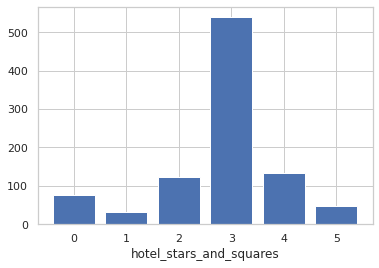

number of nulls: 0
number of categories: 6
counter of categories: Counter({3: 539, 4: 133, 2: 123, 0: 75, 5: 47, 1: 33})
mode and number of mode: [(3, 539)]
count    950.000000
mean       2.803158
std        1.131124
min        0.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: hotel_stars_and_squares, dtype: float64


In [1369]:
eda_bar(properties_info['hotel_stars_and_squares'])

### hotel_price

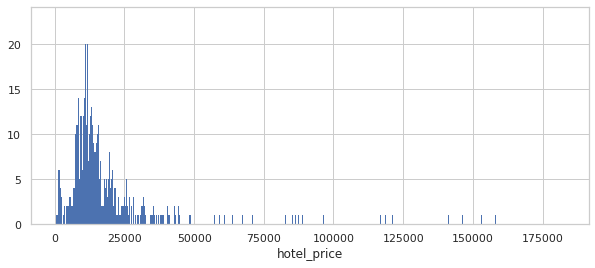

number of nulls: 0
number of categories: 800
mode and number of mode: [(1396.0, 8)]
count       950.000000
mean      17775.567368
std       19124.257261
min         465.000000
25%        9639.250000
50%       12827.500000
75%       19436.250000
max      182463.000000
Name: hotel_price, dtype: float64


In [1370]:
plt.figure(figsize=(10, 4))
eda_hist(properties_info['hotel_price'], bins=1000)

number of nulls: 0
number of categories: 800
mode and number of mode: [(1396.0, 8)]
count       950.000000
mean      17775.567368
std       19124.257261
min         465.000000
25%        9639.250000
50%       12827.500000
75%       19436.250000
max      182463.000000
Name: hotel_price, dtype: float64


/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


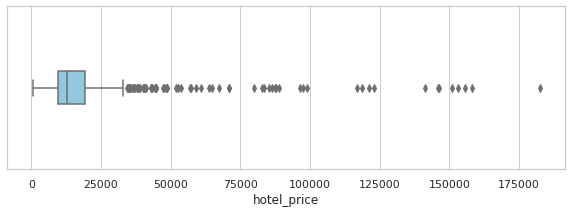

In [1239]:
plt.figure(figsize=(10, 3))
eda_boxplot(properties_info['hotel_price'])

In [1205]:
properties_info[properties_info['hotel_price']==182463]

,hotel_area,hotel_center_distance,hotel_name,hotel_price,hotel_url,hotel_usefulinfo_room,hotel_stars_and_squares,hotel_addr,hotel_hot_facilities
724,"新宿區, 東京",距中心 3.5 公里,東京柏悅酒店,182463.0,https://www.booking.com/hotel/jp/park-hyatt-tokyo.zh-tw.html?aid=304142&label=gen173nr-1FCAQoggI4_ANIMFgEaOcBiAEBmAEwuAEYyAEV2AEB6AEB-AEGiAIBqAIEuALWndydBsACAdICJDZiOGZhN2RhLWI2YmMtNDRiZC05NGY0LTRkZDQ5NjNiM2U4NNgCBeACAQ&ucfs=1&arphpl=1&checkin=2023-01-27&checkout=2023-01-31&dest_id=-246227&dest_type=city&group_adults=2&req_adults=2&no_rooms=1&group_children=0&req_children=0&hpos=25&hapos=725&sr_order=popularity&srpvid=a9d57debee5300b8&srepoch=1672941716&all_sr_blocks=17981013_112146255_2_42_0&highlighted_blocks=17981013_112146255_2_42_0&matching_block_id=17981013_112146255_2_42_0&sr_pri_blocks=17981013_112146255_2_42_0__78430000&from_sustainable_property_sr=1&from=searchresults#hotelTmpl,NaN,5,"163-1055 東京都, Shinjuku-ku, Nishishinjuku 3-7-1-2, 日本",[熱門設施室內游泳池 禁菸客房 SPA 及養生會館 健身中心 無障礙設施 客房服務 停車場（館內） 餐廳 酒吧 早餐評價超棒]


### hotel_score_digits

number of nulls: 39
number of categories: 57
mode and number of mode: [(8.3, 61)]
count    911.000000
mean       7.907574
std        0.895678
min        1.000000
25%        7.500000
50%        8.100000
75%        8.500000
max        9.800000
Name: hotel_score_digits, dtype: float64


/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


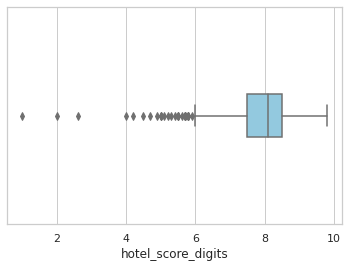

In [1371]:
eda_boxplot(properties_details['hotel_score_digits'])

### hotel_score_words

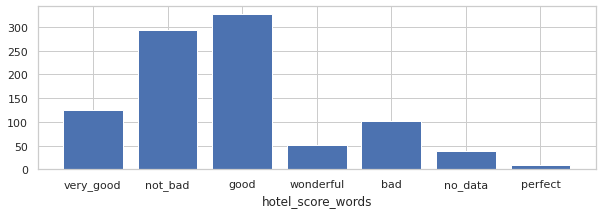

number of nulls: 0
number of categories: 7
counter of categories: Counter({'good': 327, 'not_bad': 294, 'very_good': 126, 'bad': 102, 'wonderful': 52, 'no_data': 39, 'perfect': 10})
mode and number of mode: [('good', 327)]
count      950
unique       7
top       good
freq       327
Name: hotel_score_words, dtype: object


In [1241]:
plt.figure(figsize=(10, 3))
eda_bar(properties_details['hotel_score_words'])

### hotel_score_comment

/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


number of nulls: 39
number of categories: 577
mode and number of mode: [(1.0, 18)]
count     911.000000
mean      550.568606
std       770.162611
min         1.000000
25%        51.500000
50%       265.000000
75%       787.500000
max      7868.000000
Name: hotel_score_comment, dtype: float64


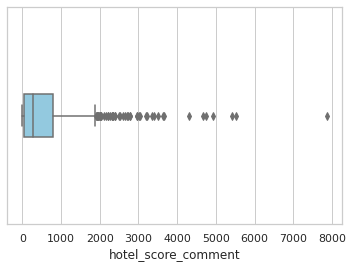

In [1242]:
eda_boxplot(properties_details['hotel_score_comment'])

### df_hotel_subscore

In [1244]:
properties_subscores.columns

Index(['hotel_url', 'location', 'free_wifi', 'staff', 'c/p_ratio', 'cleanliness', 'comfort', 'facilities', 'hotel_name'], dtype='object')

number of nulls: 13
number of categories: 46
mode and number of mode: [(8.2, 52)]
count    777.000000
mean       8.053925
std        0.796020
min        2.500000
25%        7.600000
50%        8.100000
75%        8.600000
max        9.800000
Name: location, dtype: float64


/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


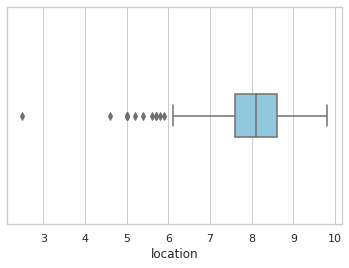

In [1245]:
eda_boxplot(properties_subscores['location'])

number of nulls: 182
number of categories: 39
mode and number of mode: [(8.5, 61)]
count    608.000000
mean       8.253125
std        0.851507
min        2.500000
25%        7.900000
50%        8.400000
75%        8.800000
max        9.800000
Name: free_wifi, dtype: float64


/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


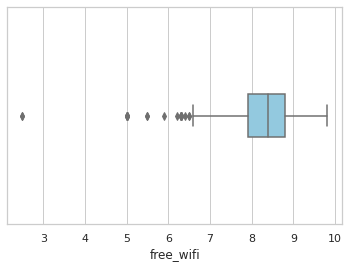

In [1246]:
eda_boxplot(properties_subscores['free_wifi'])

number of nulls: 15
number of categories: 45
mode and number of mode: [(8.8, 73)]
count    775.000000
mean       8.454839
std        0.765469
min        2.500000
25%        8.100000
50%        8.600000
75%        8.900000
max       10.000000
Name: staff, dtype: float64


/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


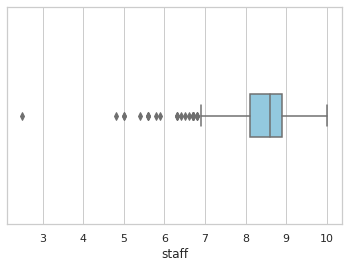

In [1247]:
eda_boxplot(properties_subscores['staff'])

/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


number of nulls: 16
number of categories: 45
mode and number of mode: [(8.4, 63)]
count    774.000000
mean       8.183592
std        0.817073
min        2.500000
25%        7.900000
50%        8.300000
75%        8.700000
max        9.800000
Name: c/p_ratio, dtype: float64


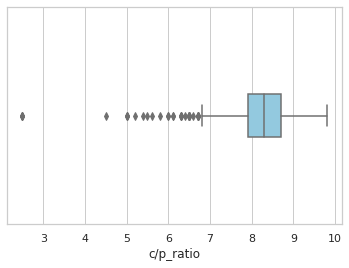

In [1248]:
eda_boxplot(properties_subscores['c/p_ratio'])

number of nulls: 16
number of categories: 45
mode and number of mode: [(8.8, 63)]
count    774.000000
mean       8.382687
std        0.877569
min        2.500000
25%        8.000000
50%        8.600000
75%        9.000000
max        9.800000
Name: cleanliness, dtype: float64


/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


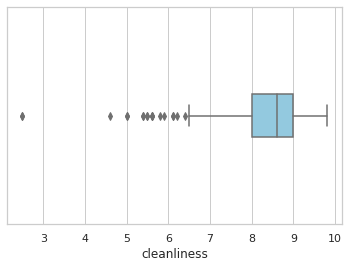

In [1249]:
eda_boxplot(properties_subscores['cleanliness'])

/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


number of nulls: 17
number of categories: 47
mode and number of mode: [(8.8, 56)]
count    773.000000
mean       8.360802
std        0.901540
min        2.500000
25%        7.900000
50%        8.500000
75%        9.000000
max        9.900000
Name: comfort, dtype: float64


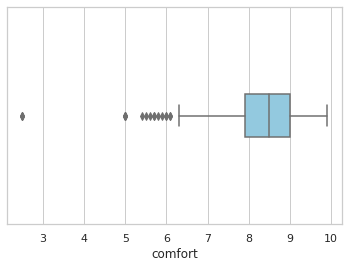

In [1250]:
eda_boxplot(properties_subscores['comfort'])

number of nulls: 14
number of categories: 47
mode and number of mode: [(8.6, 54)]
count    776.000000
mean       8.184794
std        0.878107
min        2.500000
25%        7.700000
50%        8.300000
75%        8.800000
max        9.800000
Name: facilities, dtype: float64


/home/a92340a/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


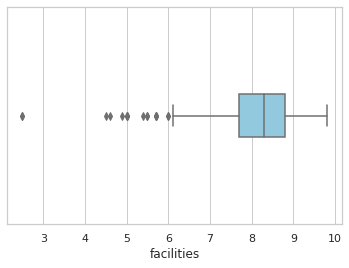

In [1251]:
eda_boxplot(properties_subscores['facilities'])

### Pearson 相關係數

In [1264]:
properties_info.columns

Index(['hotel_area', 'hotel_center_distance', 'hotel_name', 'hotel_price', 'hotel_url', 'hotel_usefulinfo_room', 'hotel_stars_and_squares', 'hotel_addr', 'hotel_hot_facilities'], dtype='object')

In [1265]:
properties_details.columns

Index(['hotel_url', 'hotel_name', 'hotel_hot_comment_keywords', 'hotel_highlights_new', 'hotel_score_digits', 'hotel_score_words', 'hotel_score_comment'], dtype='object')

In [1334]:
df_corr = pd.merge(properties_details[['hotel_url','hotel_score_digits','hotel_score_comment','hotel_hot_comment_keywords','hotel_highlights_new']],properties_info[['hotel_url','hotel_price','hotel_stars_and_squares','hotel_area','hotel_center_distance','hotel_hot_facilities']],on='hotel_url',how='inner')

In [1335]:
df_corr['hotel_highlights_cnt'] = df_corr[['hotel_highlights_new']].applymap(lambda x:len(x) if x is not None else None).fillna(0).astype(int)
df_corr['hotel_hot_keywords_cnt'] = df_corr[['hotel_hot_comment_keywords']].applymap(lambda x:len(x) if x is not None else None)
df_corr['hotel_hot_facilities_cnt'] = df_corr[['hotel_hot_facilities']].applymap(lambda x:len(x) if x is not None else None)
df_corr['hotel_center_distance_num'] = df_corr['hotel_center_distance'].str.extract(r'.*(\d{1,2}\.[0-9]).*',expand=False)

In [1336]:
df_corr = pd.merge(df_corr,pd.get_dummies(df_corr[['hotel_area']]),left_index=True,right_index=True,how='left')
df_corr.drop(['hotel_url','hotel_highlights_new','hotel_hot_comment_keywords','hotel_hot_facilities','hotel_area','hotel_center_distance'],axis=1,inplace=True)

In [1337]:
df_corr.head(2)

,hotel_score_digits,hotel_score_comment,hotel_price,hotel_stars_and_squares,hotel_highlights_cnt,hotel_hot_keywords_cnt,hotel_hot_facilities_cnt,hotel_center_distance_num,"hotel_area_世田谷區, 東京","hotel_area_中央區, 東京","hotel_area_中野區, 東京","hotel_area_北區, 東京","hotel_area_千代田區, 東京","hotel_area_台東區, 東京","hotel_area_品川區, 東京","hotel_area_墨田區, 東京","hotel_area_大田區, 東京","hotel_area_文京區, 東京","hotel_area_新宿區, 東京","hotel_area_杉並區, 東京",hotel_area_東京,"hotel_area_板橋區, 東京","hotel_area_江戶川區, 東京","hotel_area_江東區, 東京","hotel_area_浦安市, 東京","hotel_area_港區, 東京","hotel_area_澀谷區, 東京","hotel_area_目黑區, 東京","hotel_area_秋葉原, 東京","hotel_area_練馬區, 東京","hotel_area_荒川, 東京","hotel_area_葛飾區, 東京","hotel_area_豐島區, 東京","hotel_area_足立區, 東京"
0,8.6,537.0,12589.0,4,0,0,0,6.8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.6,499.0,14120.0,3,2,4,6,2.2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


/home/a92340a/.local/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 19990 (\N{CJK UNIFIED IDEOGRAPH-4E16}) missing from current font.
  fig.canvas.draw()
/home/a92340a/.local/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 30000 (\N{CJK UNIFIED IDEOGRAPH-7530}) missing from current font.
  fig.canvas.draw()
/home/a92340a/.local/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 35895 (\N{CJK UNIFIED IDEOGRAPH-8C37}) missing from current font.
  fig.canvas.draw()
/home/a92340a/.local/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 21312 (\N{CJK UNIFIED IDEOGRAPH-5340}) missing from current font.
  fig.canvas.draw()
/home/a92340a/.local/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from current font.
  fig.canvas.draw()
/home/a92340a/.local/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAP

<AxesSubplot: >

/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 19990 (\N{CJK UNIFIED IDEOGRAPH-4E16}) missing from current font.
  func(*args, **kwargs)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 30000 (\N{CJK UNIFIED IDEOGRAPH-7530}) missing from current font.
  func(*args, **kwargs)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 35895 (\N{CJK UNIFIED IDEOGRAPH-8C37}) missing from current font.
  func(*args, **kwargs)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 21312 (\N{CJK UNIFIED IDEOGRAPH-5340}) missing from current font.
  func(*args, **kwargs)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from current font.
  func(*args, **kwargs)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/events.

/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19990 (\N{CJK UNIFIED IDEOGRAPH-4E16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30000 (\N{CJK UNIFIED IDEOGRAPH-7530}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35895 (\N{CJK UNIFIED IDEOGRAPH-8C37}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21312 (\N{CJK UNIFIED IDEOGRAPH-5340}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/a92340a/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from current fon

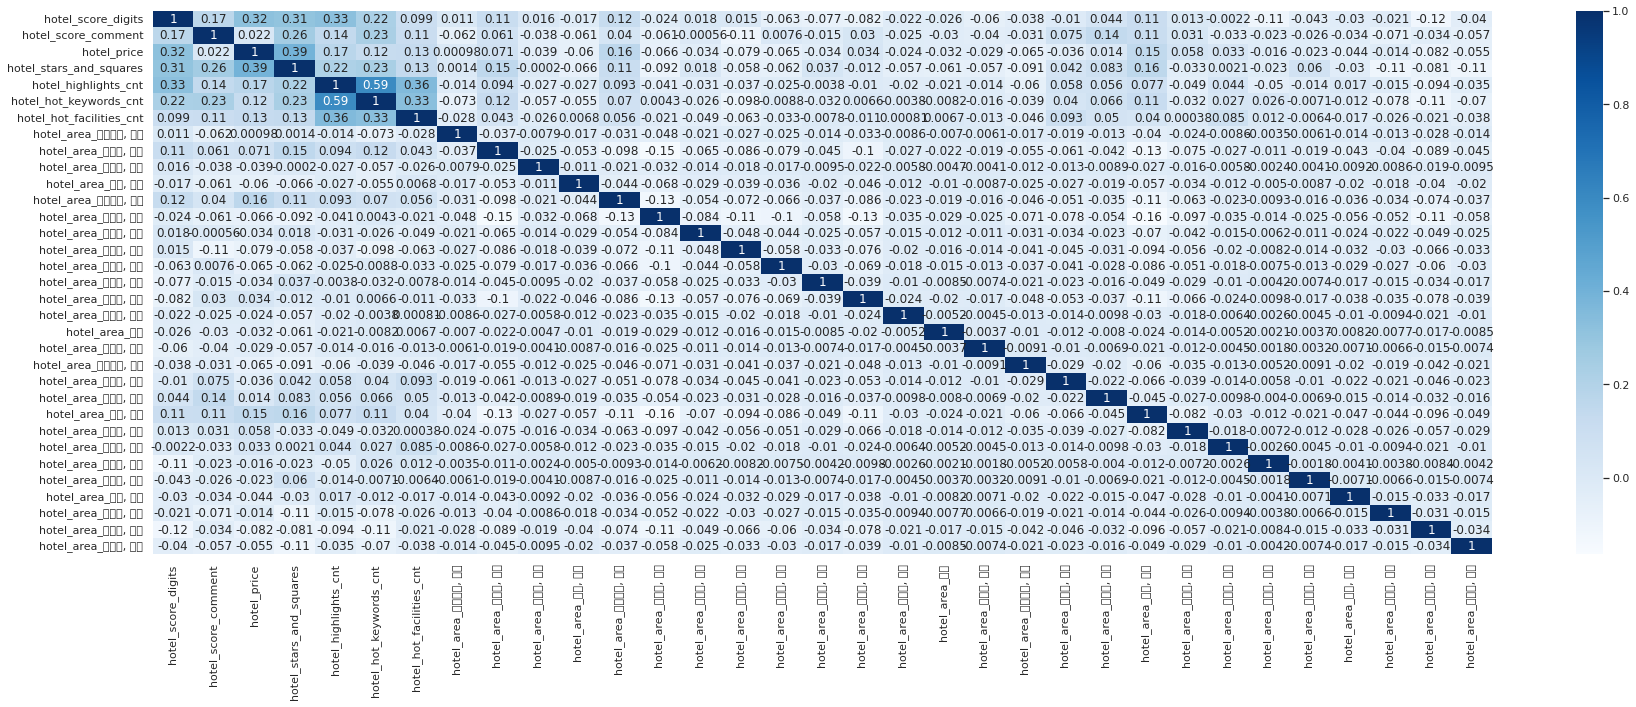

In [1338]:
booking_corr =df_corr.corr() #計算相關係數
plt.subplots(figsize=(30, 10))  # 設置長寬尺寸大小
sns.heatmap(booking_corr, annot=True, vmax=1, cmap="Blues")